# Geissmann Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
from matplotlib_venn import venn3, venn2
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

## Preprocessing

In [4]:
# file directories
workingDirectory = '/home/jenhan/analysis/geissman_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath = workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'

# tagDirPath = workingDirectory + '/all_tag_directories/'
# logFilePath = workingDirectory + '/all_log_files/'




os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(logFilePath):
    for gen in genomes:
        rootName = f.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip()
    owner = metaDataTokens[4].strip()
#     date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
#     dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = ''.join([x for x in t.split('-') if 'Diet' in x])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile.replace('.mm10.star.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

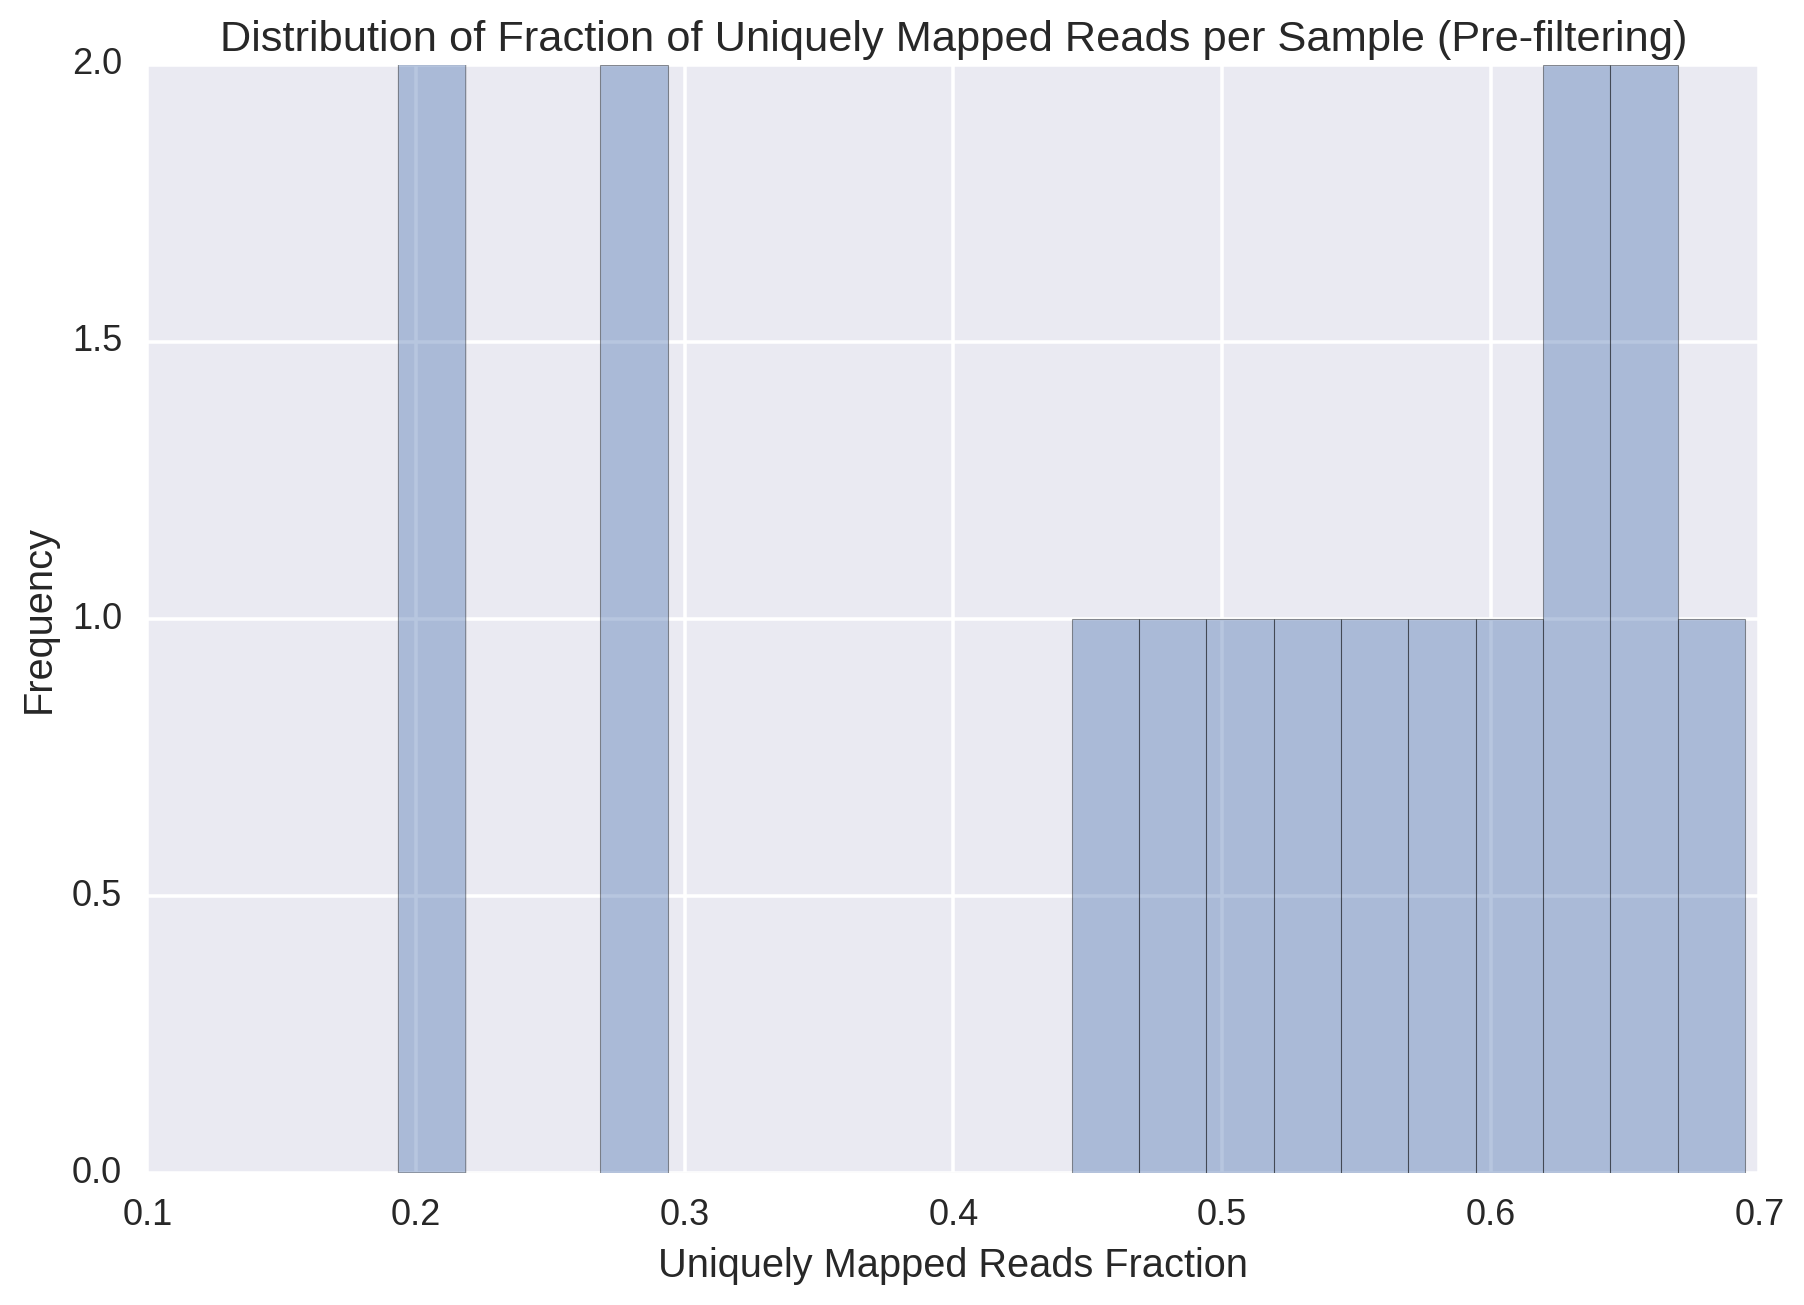

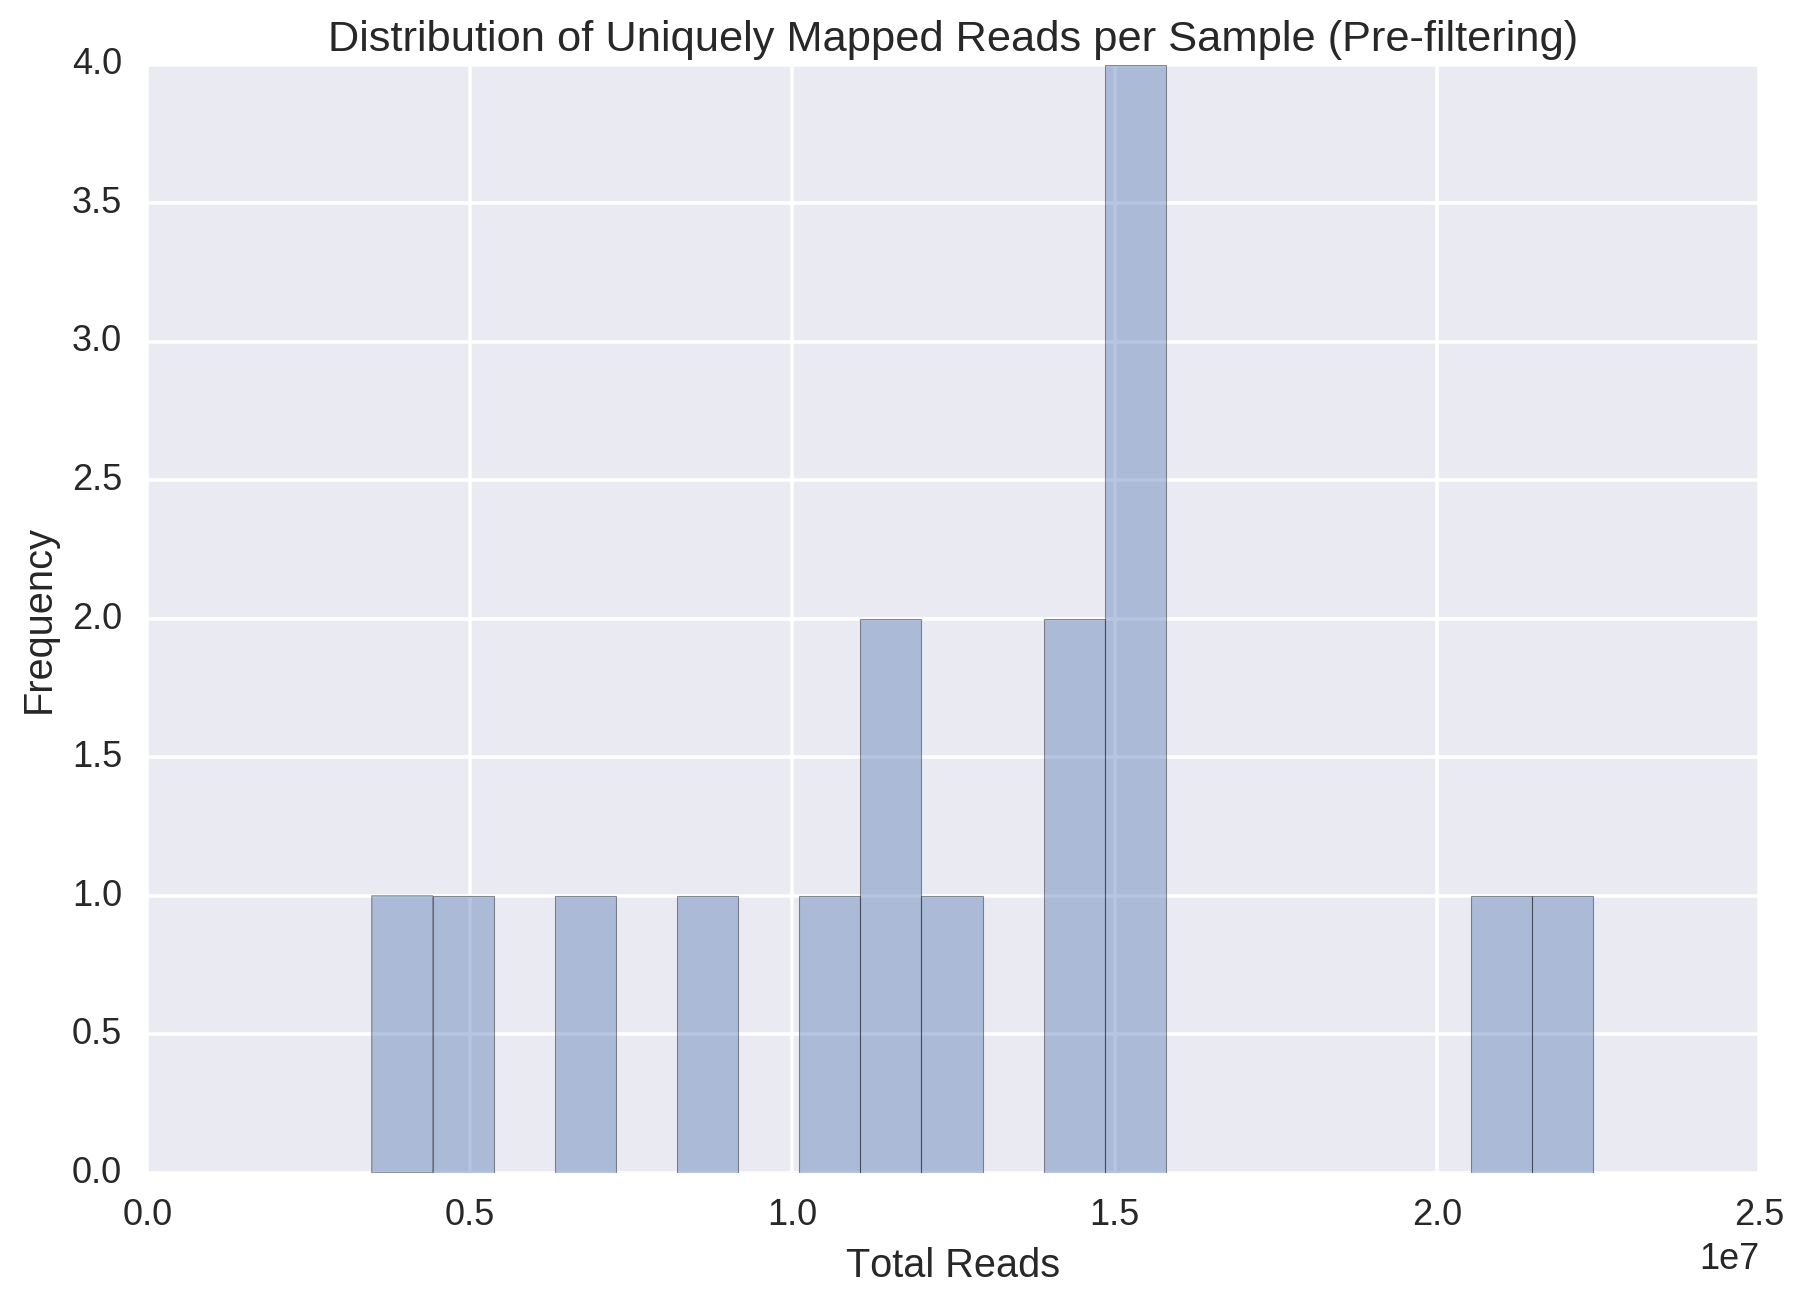

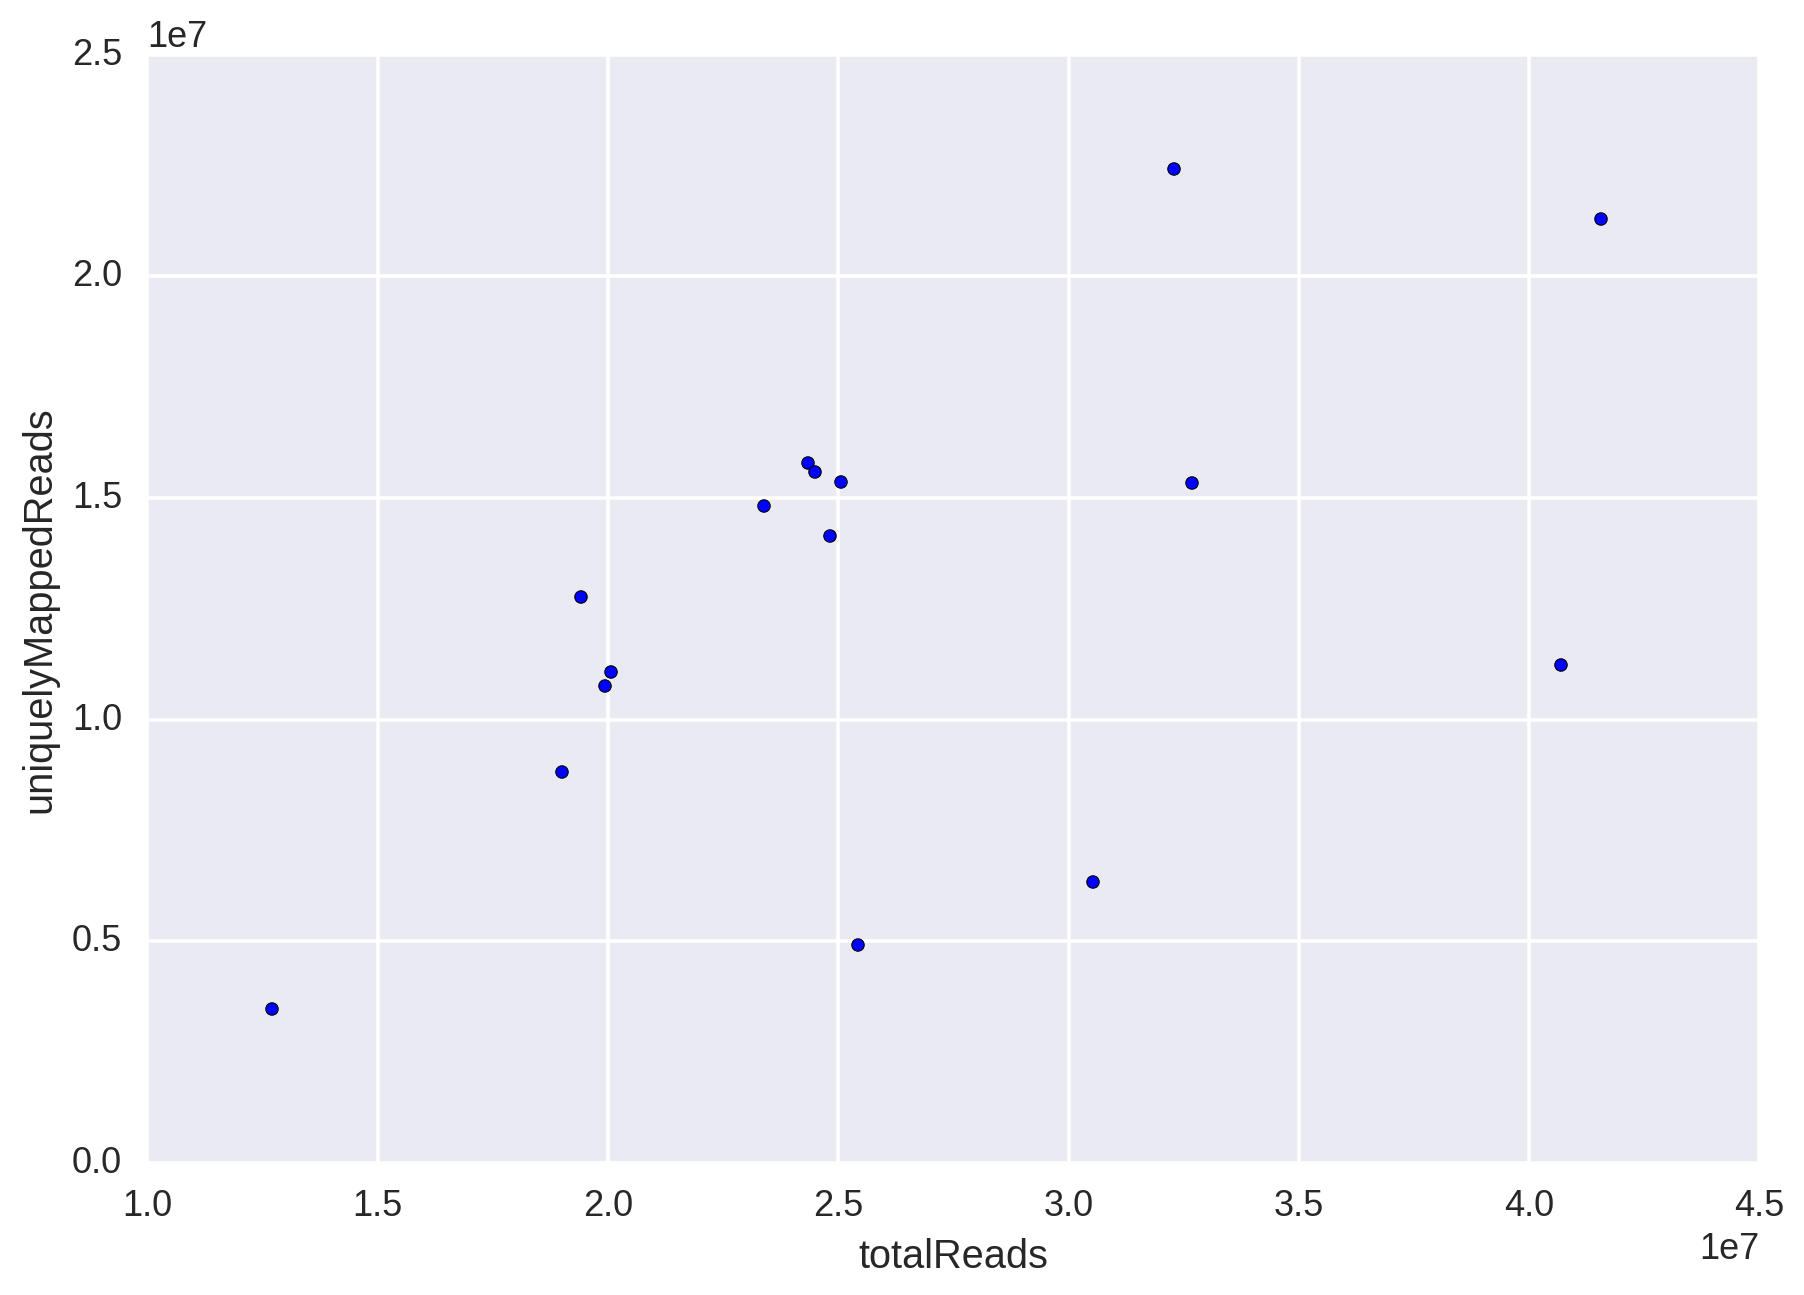

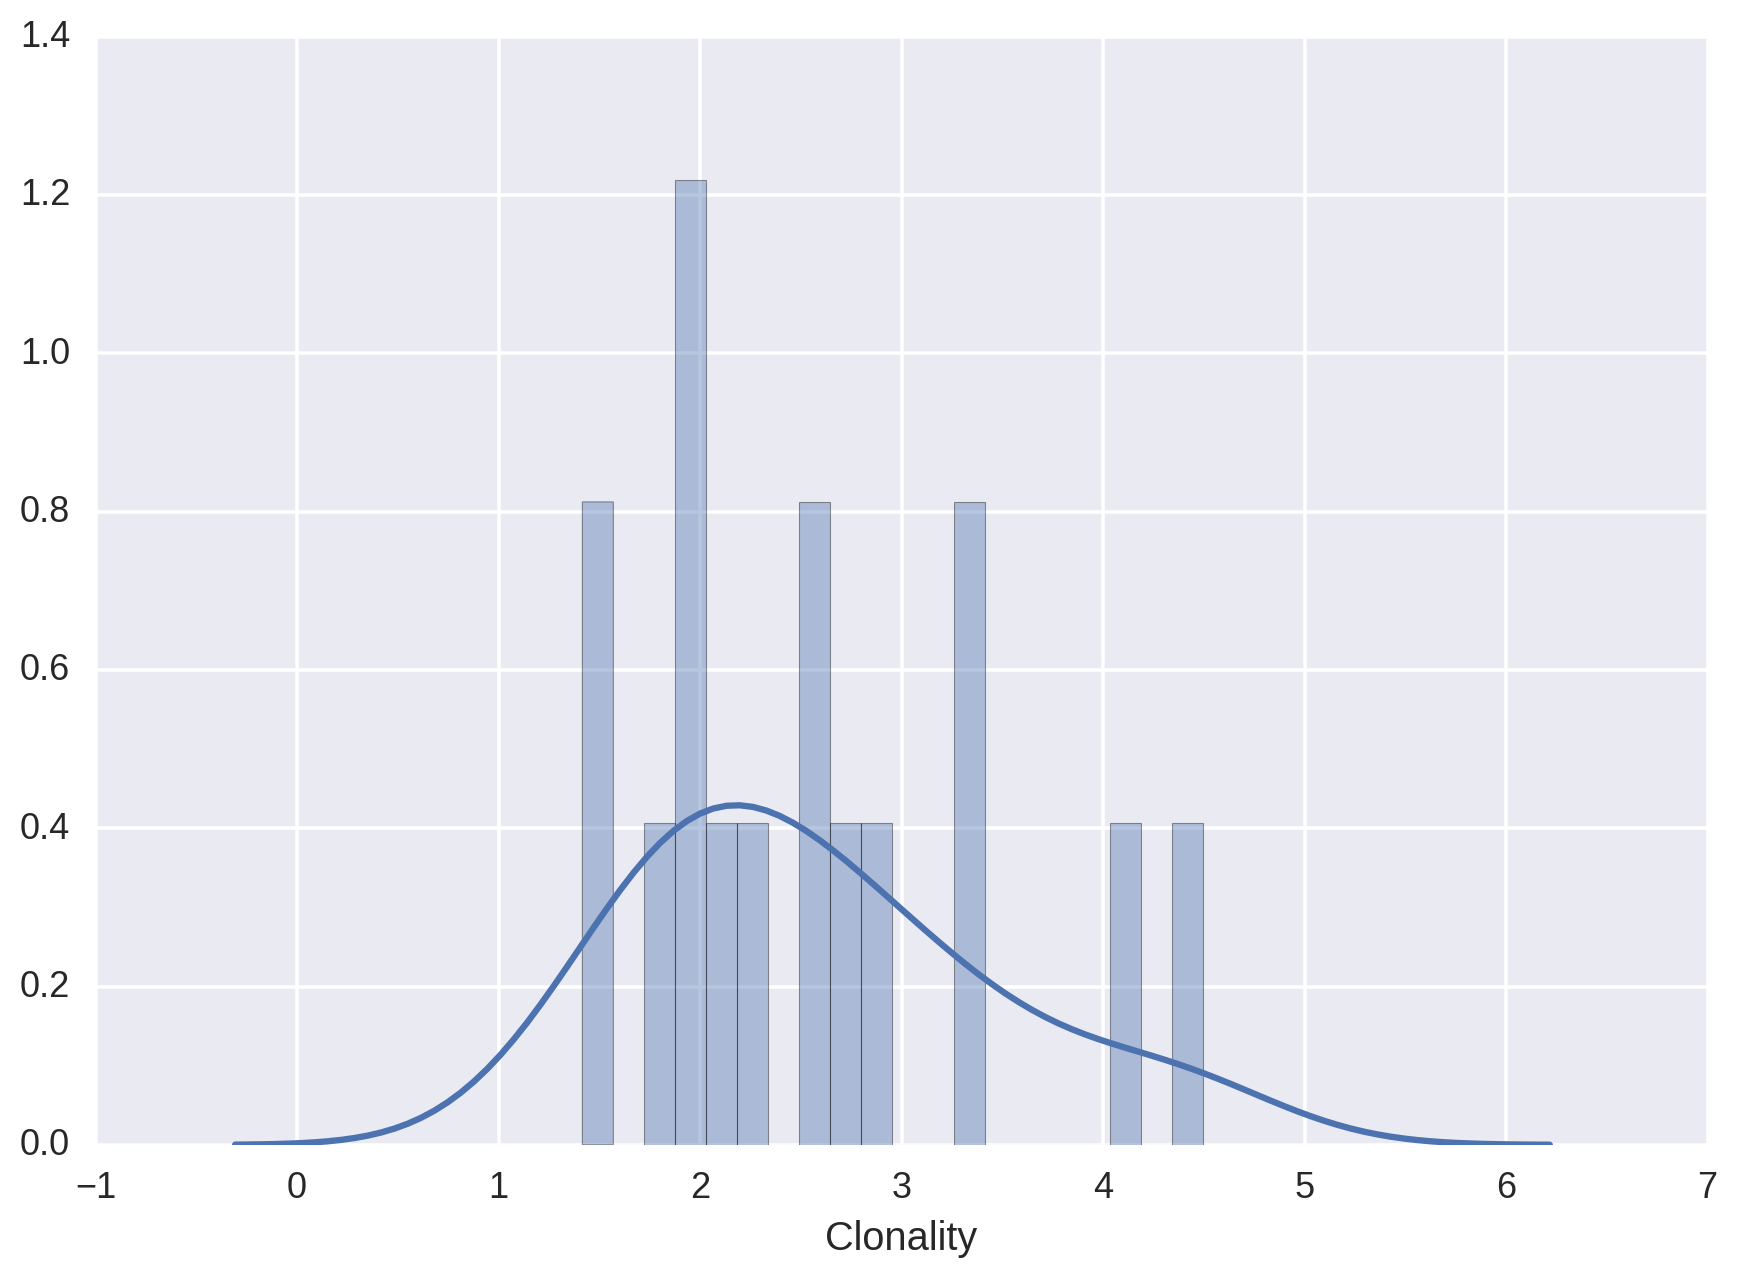

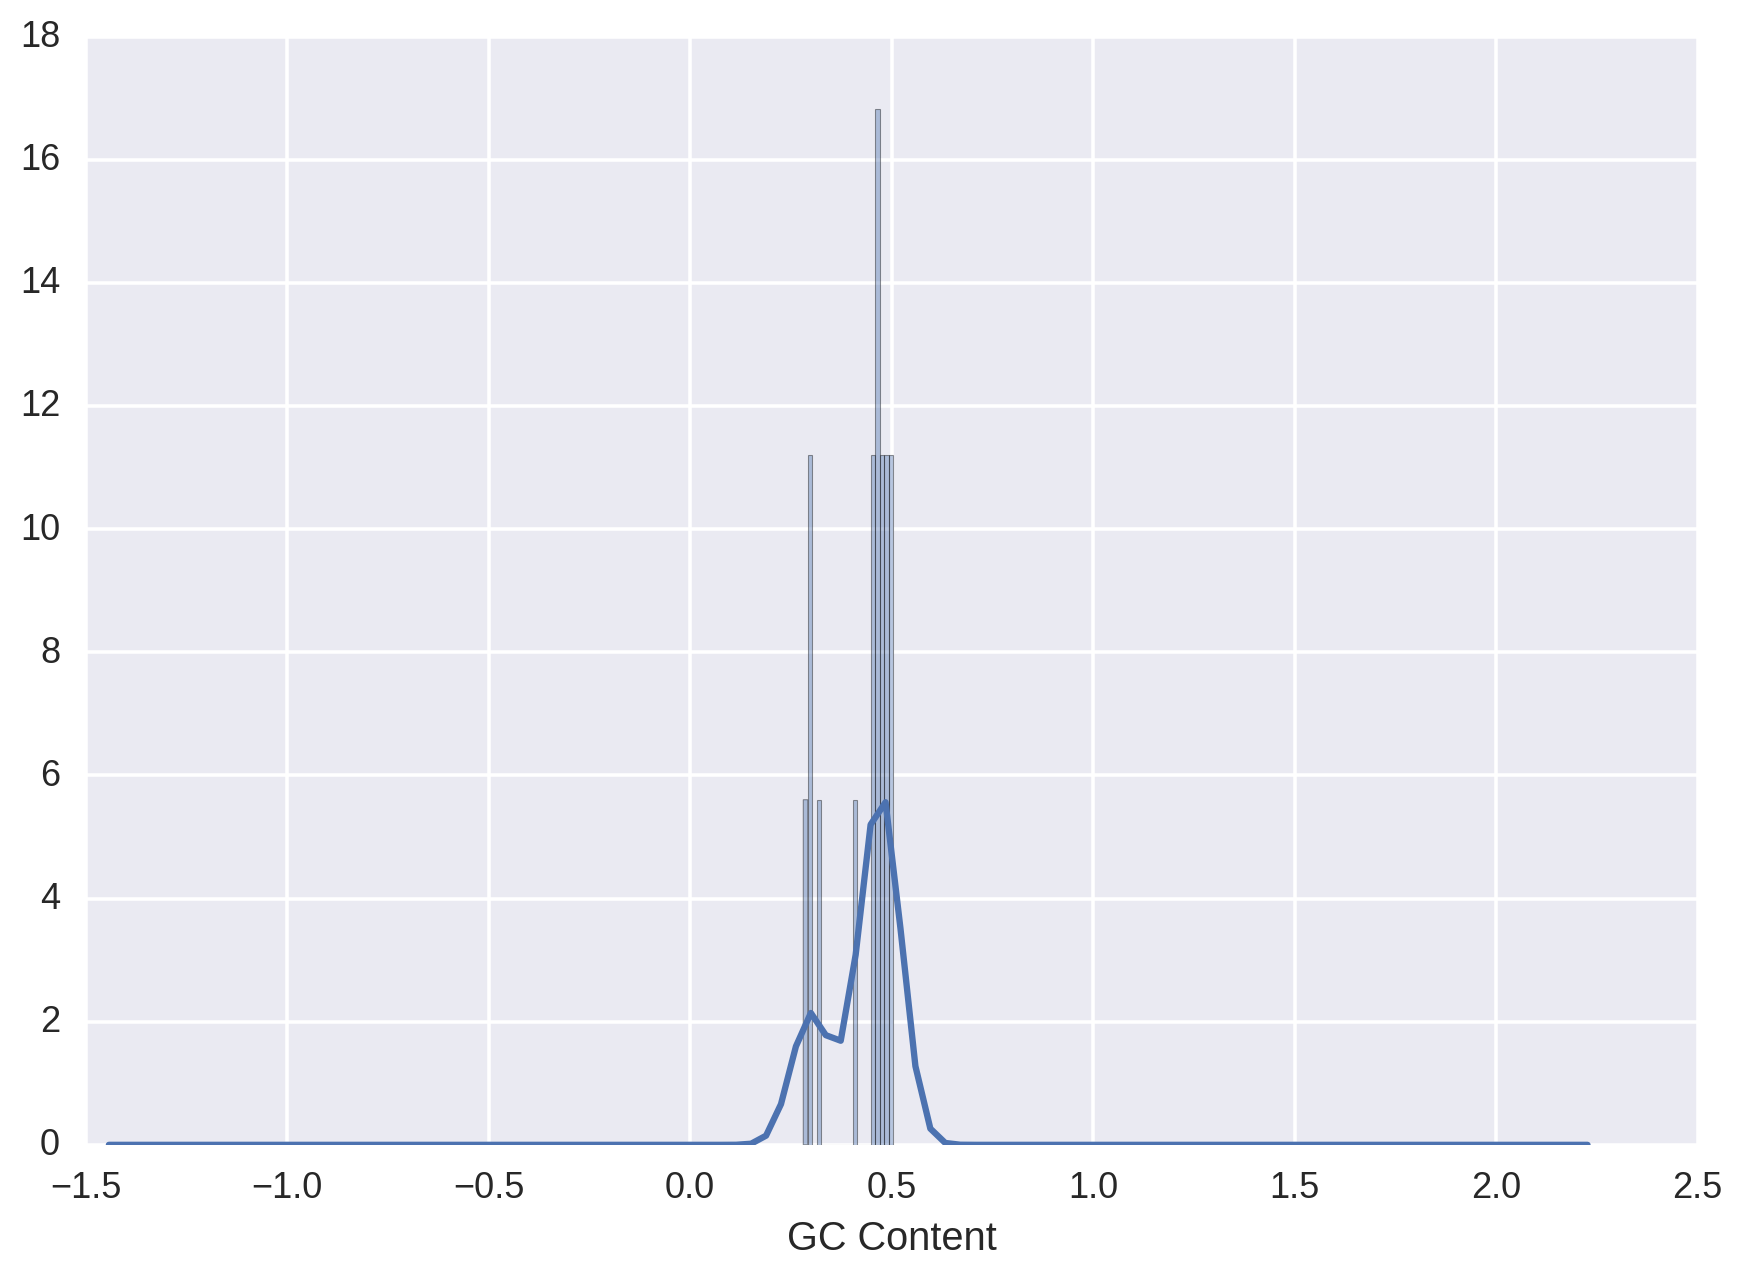

In [5]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.show()


### Filter Samples According to Mapping Quality

In [6]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.00
uniquelyMappedReadThreshold = 4000000
pbcThreshold=0.0
gcThreshold=0.20
clonalityThreshold =3.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]






# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["simpleTreatment"].values
for simpleNameRoot in simpleTreatmentCombos:
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 



Number of Samples: 16
Number of discarded samples: 4
Number of Samples remaining after filtering: 12


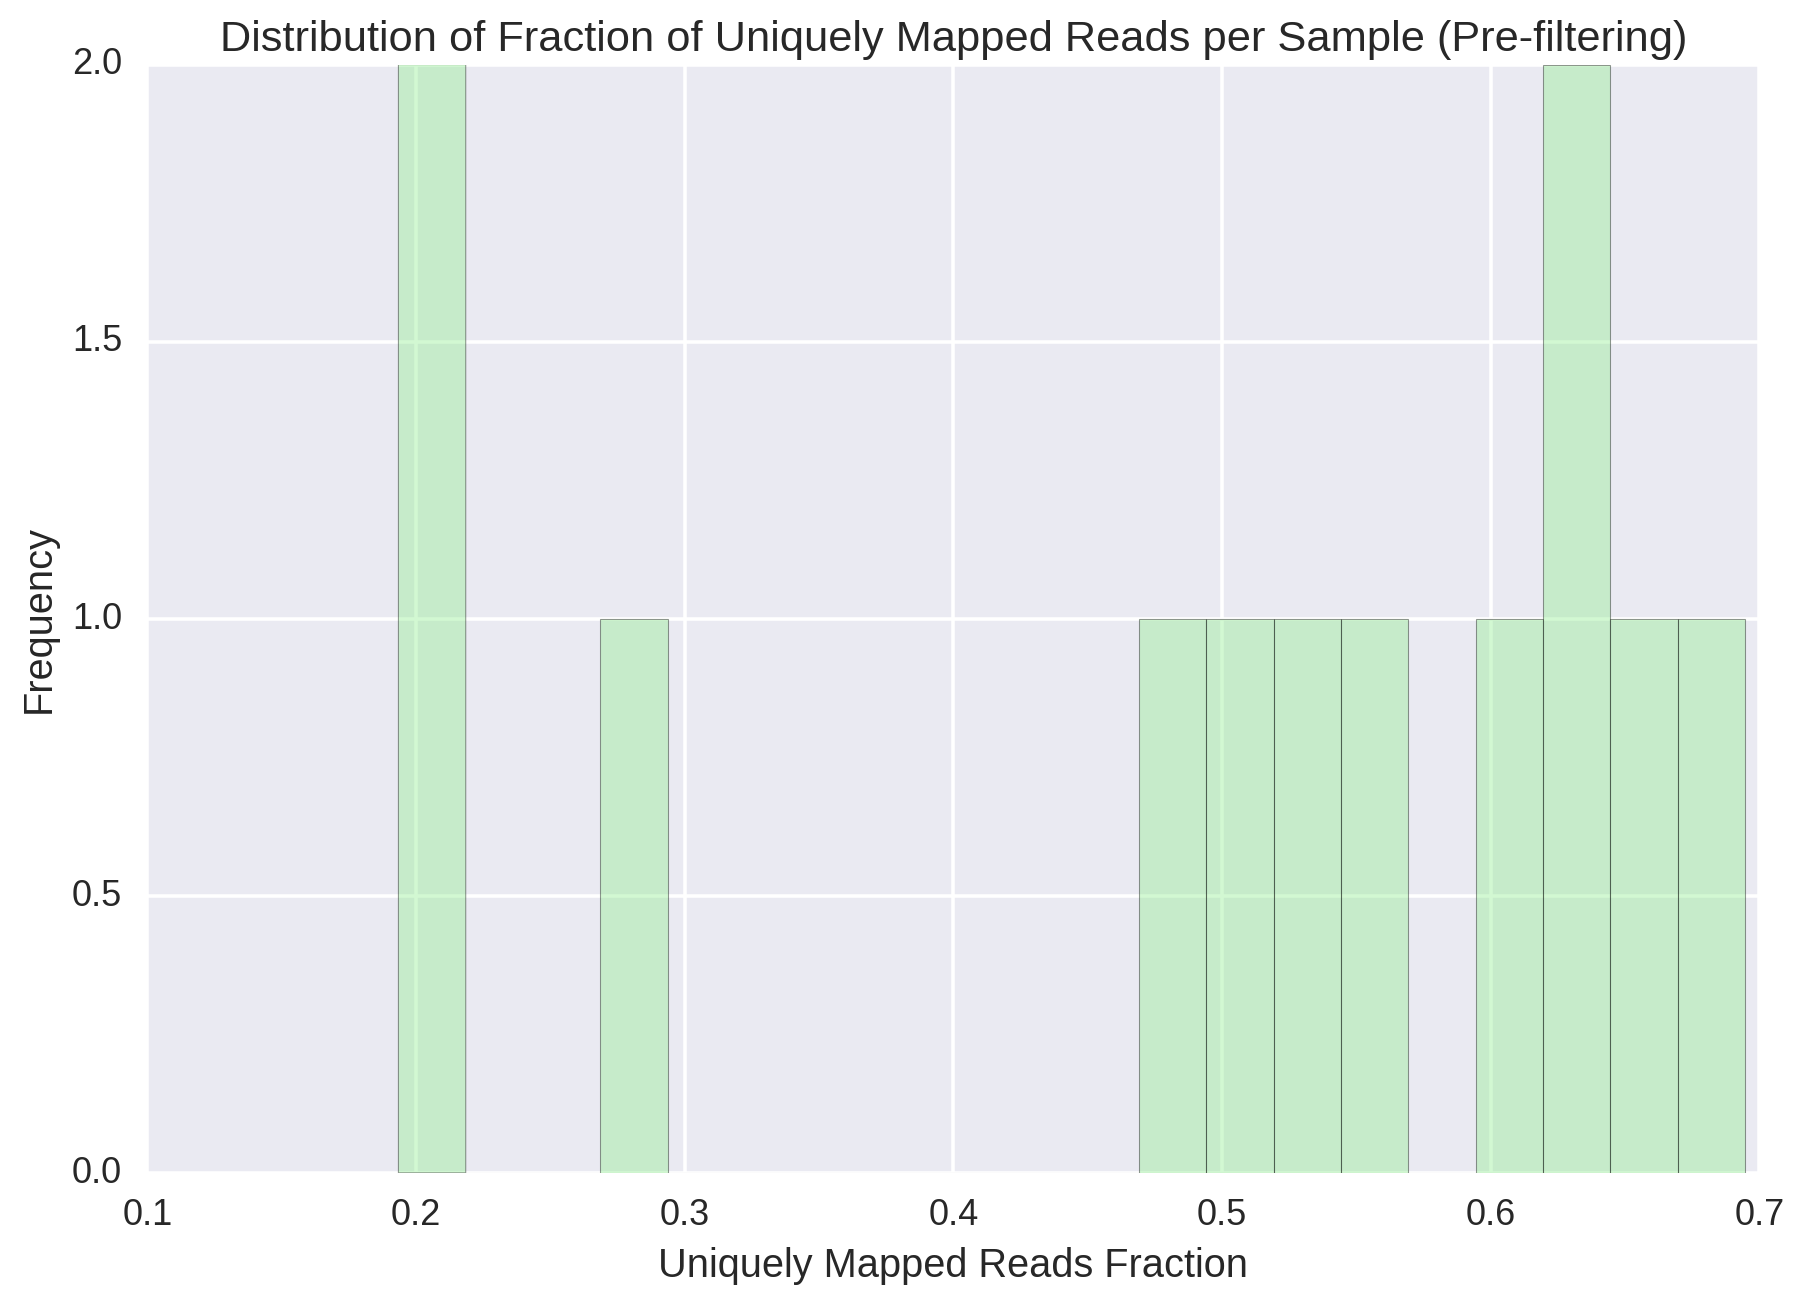

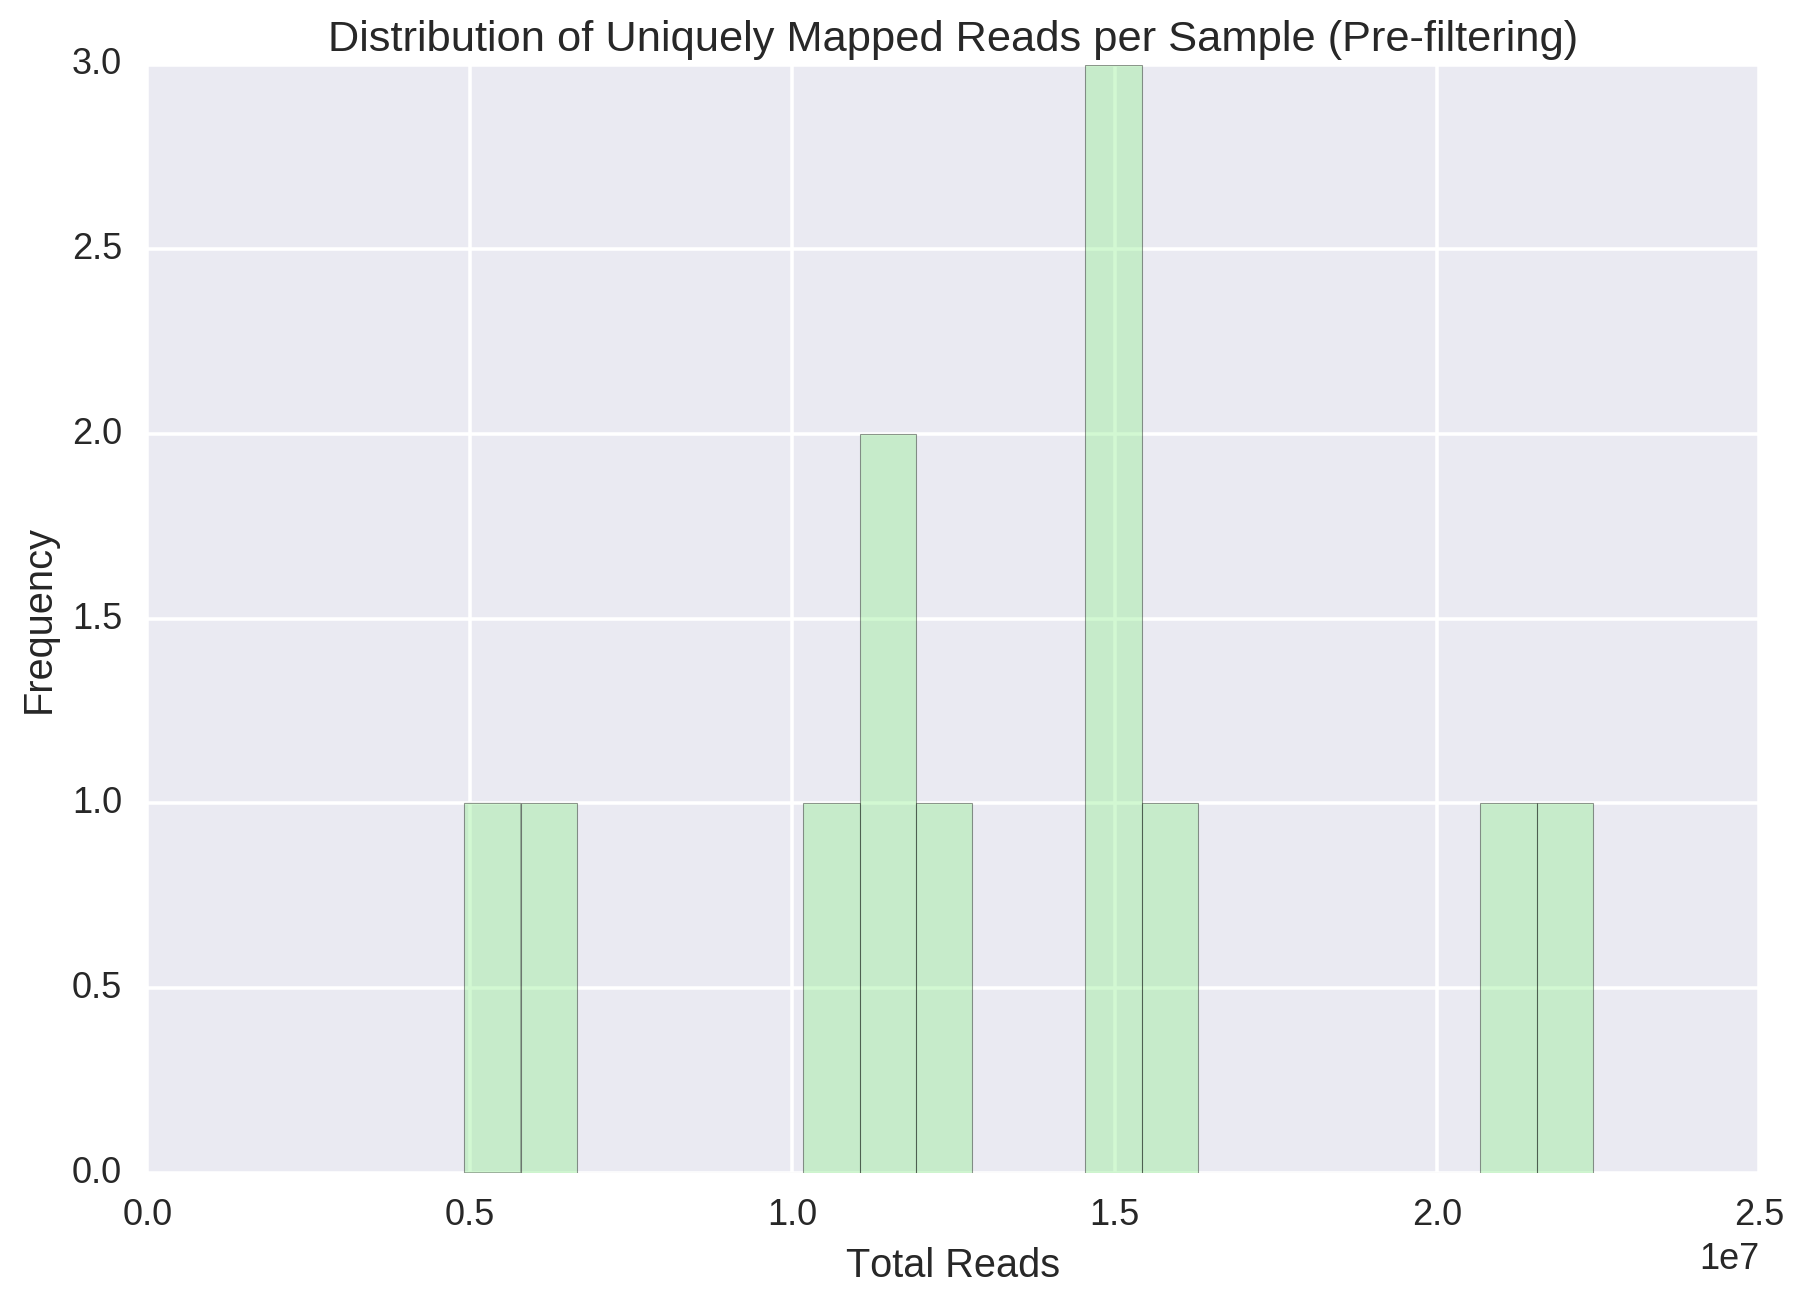

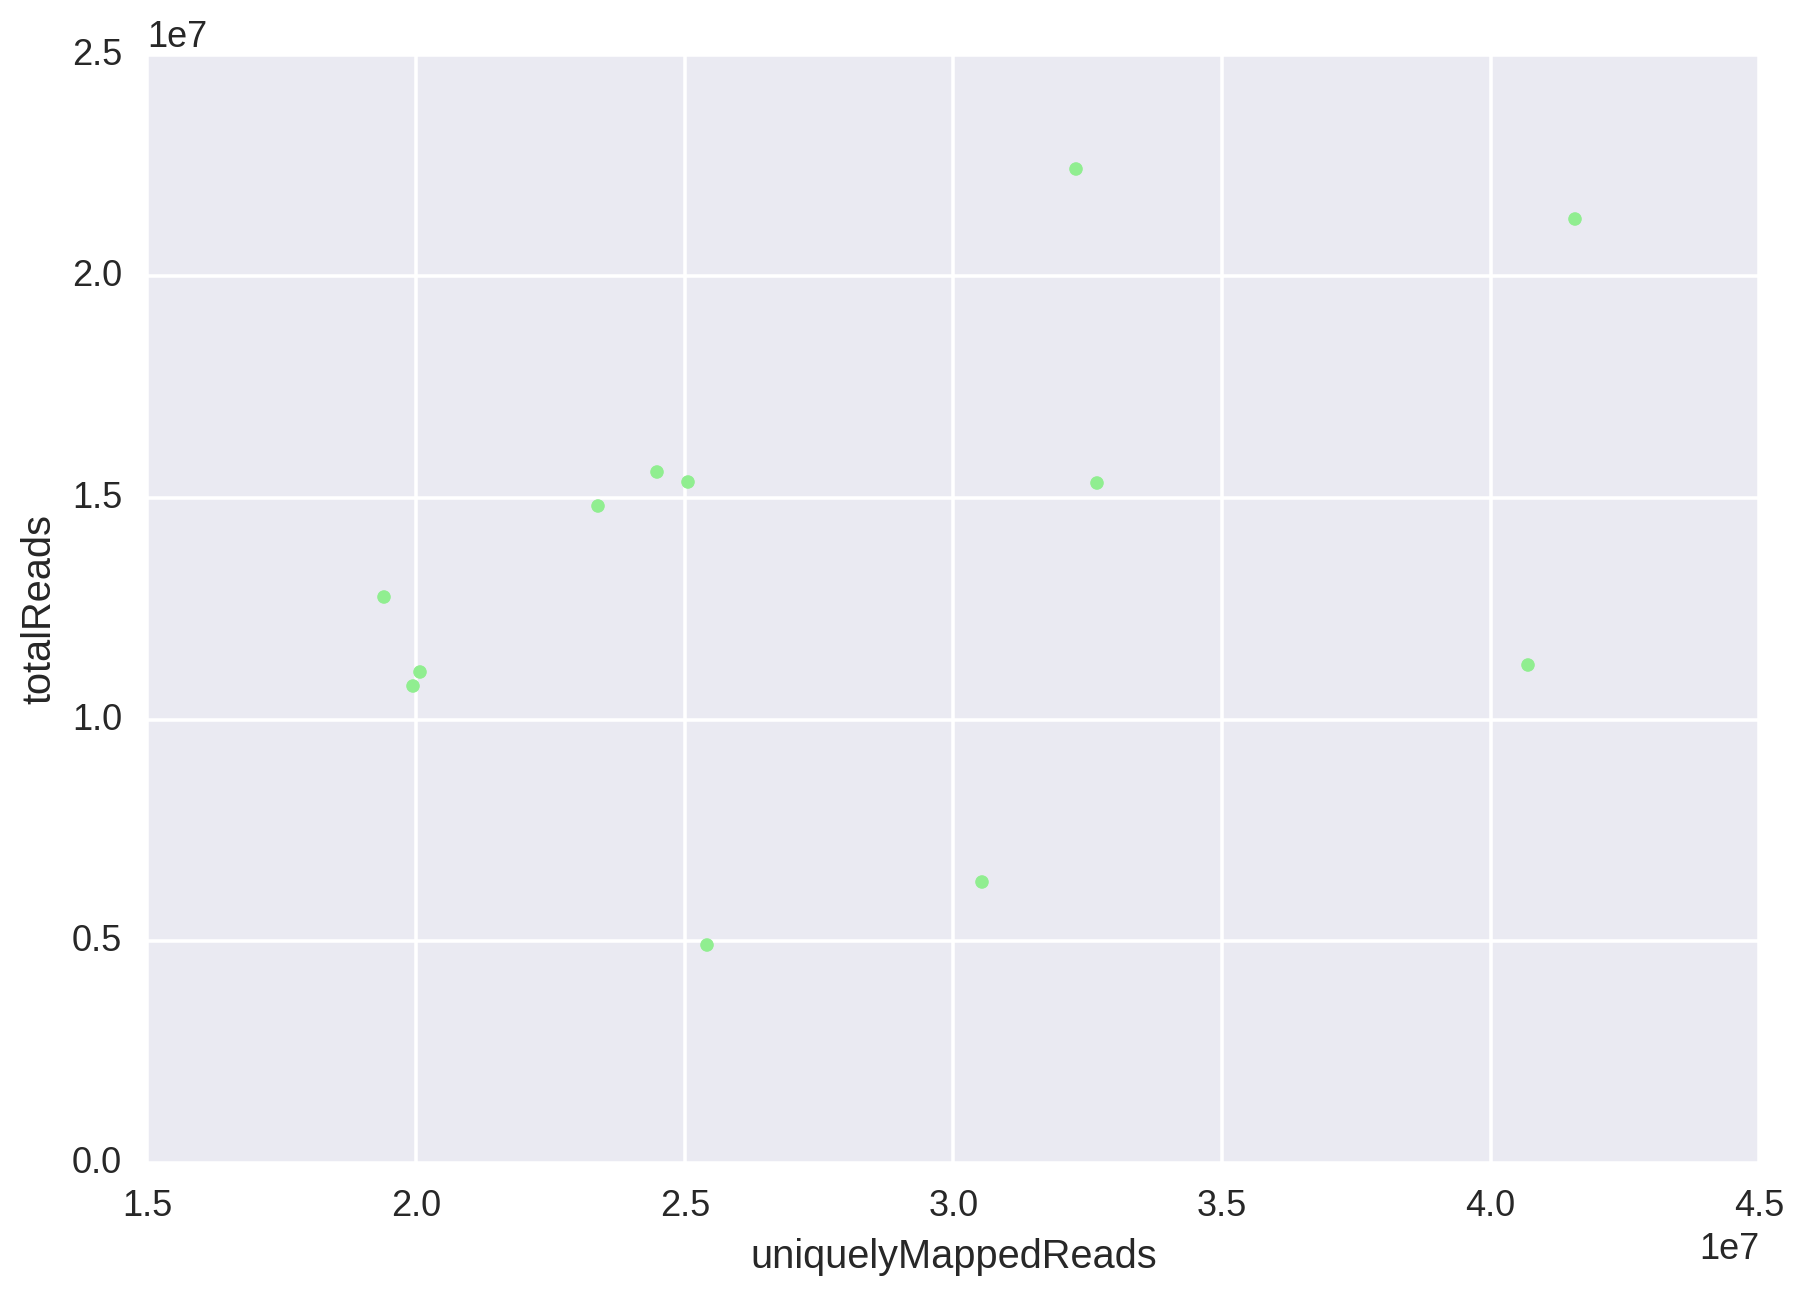

In [7]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()






## Calculate Tag Counts and RPKM

In [44]:
%%capture
filteredTagDirectories = ' '.join([tagDirPath + x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/geissman_analysis//rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/geissman_analysis//raw.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/geissman_analysis//normed.tsv

In [8]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("normed.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



## Run IDR

In [9]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
originalName_strain_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['strain']))

conditions = " ".join([originalName_strain_dict[x] + '_' + originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/geissman_analysis//idr/ Monocyte_CDiet Monocyte_CDiet Monocyte_HFDiet Monocyte_HFDiet eWAT-Macrophage_CDiet eWAT-Macrophage_CDiet eWAT-Macrophage_CDiet eWAT-Macrophage_HFDiet eWAT-Macrophage_HFDiet eWAT-Macrophage_HFDiet eWAT-Macrophage_HFDiet eWAT-Macrophage_HFDiet
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/geissman_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/geissman_analysis//tag_directories/C57Bl6_Monocyte_RNA_CDiet-2_NJS_15-06-16 reads FPKM 	 Monocyte_CDiet
/home/jenhan/analysis/geissman_analysis//tag_directories/C57Bl6_Monocyte_RNA_CDiet-1_NJS

## Calcuate Differential Expression with EdgeR

In [34]:
%%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['strain'] + '_' +filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv

In [52]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [81]:
!rm ./gene_ontology/*

treatment_up_dict = {}
treatment_down_dict = {}

if not os.path.isdir('gene_ontology'):
    os.mkdir('gene_ontology')
    
fdr_threshold = 0.05

# fdrColumns = [x for x in diffExpression_frame.columns if 'FDR' in x and not '1um-Mepip' in x and not '30' in x]
fdrColumns = [x for x in diffExpression_frame.columns if 'FDR' in x]
fdrColumns = [x for x in diffExpression_frame.columns if 'PValue' in x]




for c in fdrColumns:
    tokens = c.split()
    treatment1 = tokens[0]
    treatment2 = tokens[2]
    print(treatment1, treatment2)
    fc_column = c.replace('PValue', 'logFC')

    current_frame = diffExpression_frame[diffExpression_frame[c] < fdr_threshold][[c, fc_column, 'gene']]
    if 'cdiet' in treatment1.lower():
        up_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
        down_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values
        treatment = treatment2
    else:
        treatment = treatment1
        down_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
        up_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values

    treatment_up_dict[treatment] = up_genes
    treatment_down_dict[treatment] = down_genes

    # wrtite genes for gene ontology
    up_file = open('./gene_ontology/' + treatment + '_up.txt', 'w')
    for g in up_genes:
        up_file.write(g.upper() + '\n')
    up_file.close()

    down_file = open('./gene_ontology/' + treatment + '_down.txt', 'w')
    for g in down_genes:
        down_file.write(g.upper() + '\n')
    print(treatment, len(up_genes), len(down_genes))
    down_file.close()


Monocyte_CDiet Monocyte_HFDiet
Monocyte_HFDiet 1092 4361
Monocyte_CDiet eWAT-Macrophage_CDiet
eWAT-Macrophage_CDiet 1067 5528
Monocyte_CDiet eWAT-Macrophage_HFDiet
eWAT-Macrophage_HFDiet 2853 7237
Monocyte_HFDiet eWAT-Macrophage_CDiet
Monocyte_HFDiet 2306 2614
Monocyte_HFDiet eWAT-Macrophage_HFDiet
Monocyte_HFDiet 4465 3657
eWAT-Macrophage_CDiet eWAT-Macrophage_HFDiet
eWAT-Macrophage_HFDiet 324 1241


In [72]:
### make Venn Diagrams
if not os.path.isdir('./diffExpressed_vennDiagrams'):
    os.mkdir('./diffExpressed_vennDiagrams')
treatments = sorted(treatment_up_dict.keys())
for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        print(treatment1, treatment2)
        up_1 = set(treatment_up_dict[treatment1])
        up_2 = set(treatment_up_dict[treatment2])
        
        down_1 = set(treatment_down_dict[treatment1])
        down_2 = set(treatment_down_dict[treatment2])
        
        up_intersection = open('./diffExpressed_vennDiagrams/'  + treatment1 + '_' + treatment2 + '_up_vs_veh_intersection.txt','w')
        for gene in sorted(up_1.intersection(up_2)):
            up_intersection.write(gene+ "\n")
        up_intersection.close()
        
        venn2([up_1, up_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_up_vs_veh_venn.png')
        plt.close()
        down_intersection = open('./diffExpressed_vennDiagrams/'  + treatment1 + '_' + treatment2 + '_down_vs_veh_intersection.txt','w')
        for gene in sorted(down_1.intersection(down_2)):
            down_intersection.write(gene+ "\n")
        down_intersection.close()

        venn2([down_1, down_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_down_vs_veh_venn.png')
        plt.close()

Monocyte_HFDiet eWAT-Macrophage_CDiet
Monocyte_HFDiet eWAT-Macrophage_HFDiet
eWAT-Macrophage_CDiet eWAT-Macrophage_HFDiet


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


## Tag Scatter Plots

In [19]:
# plot scatter plots for the same condition
factor = 4.0
tagCutoff = 0.0
genes = reads_frame['gene'].values
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
# for tag counts
import matplotlib
matplotlib.use('Agg')
simpleNames = list(filtered_summary_frame['simplifiedName'])
treatments = np.array(filtered_summary_frame['strain'].values) + '_' + np.array(filtered_summary_frame['simpleTreatment'].values)
seenTreatments = set()

for i in range(len(simpleNames) - 1):
    for j in range(i + 1, len(simpleNames)):
        sample1 = simpleName_originalName_dict[simpleNames[i]]
        sample2 = simpleName_originalName_dict[simpleNames[j]]
        treatment1 = treatments[i]
        treatment2 = treatments [j]
        if treatment1 == treatment2:
#             print(simpleNames[i], simpleNames[j])
            currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
            altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
            if altCurrentDir in seenTreatments:
                currentDir = altCurrentDir
            if not currentDir in seenTreatments:
                if not os.path.isdir(currentDir):
                    os.mkdir(currentDir)
                seenTreatments.add(currentDir)
            idrIntersection_frame = pd.read_csv(idrDirectory + '/' +simpleNames[i] + '_' + simpleNames[j] + '_idr.tsv', sep='\t')
            intersecting_refseqs = idrIntersection_frame['refseq']
            current_rpkm_frame = rpkm_frame[rpkm_frame['refseq'].isin(intersecting_refseqs)]
            read_list_1 = current_rpkm_frame[sample1].values
            read_list_2 = current_rpkm_frame[sample2].values
            log_read_list_1 = np.log2(read_list_1 + 0.00000001)
            log_read_list_2 = np.log2(read_list_2 + 0.00000001)

            coords = []
            labels = []
            colors = []
            fig, ax = plt.subplots()
            for x in range(len(read_list_1)):
                foldChange = read_list_1[x]/read_list_2[x]
                if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                    if foldChange >= factor or foldChange <= 1.0/factor:
                        if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                            labels.append(genes[x])
                            coords.append((log_read_list_1[x],log_read_list_2[x]))
                        colors.append('red')
                    else:
                        colors.append('blue')
                else:
                    colors.append('blue')
            sns.set_style("whitegrid",{'axes.grid': False,
                          'axes.edgecolor': 'black'})
            plt.scatter(log_read_list_1,log_read_list_2, c= colors,marker='.',s=15);
            plt.xlabel(simpleNames[i])
            plt.ylabel(simpleNames[j])
            plt.title(sample1 + " VS " + sample2 + " log normed tags")
            xylim = max(max(log_read_list_1), max(log_read_list_2))
            plt.ylim(0,xylim)
            plt.xlim(0,xylim)
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,15))
            ax.set_ylim((0,15))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))
#             for x in range(len(coords)):
#                 gene = labels[x]
#                 ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
#                         textcoords='offset points', ha='center', va='bottom',
#                         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
            plt.savefig(workingDirectory + "/" + currentDir + "/" + simpleNames[i] + "_" + simpleNames[j] + "_log.pdf",
                       bbox_inches='tight')
            plt.close()



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Monocyte_CDiet Monocyte_HFDiet


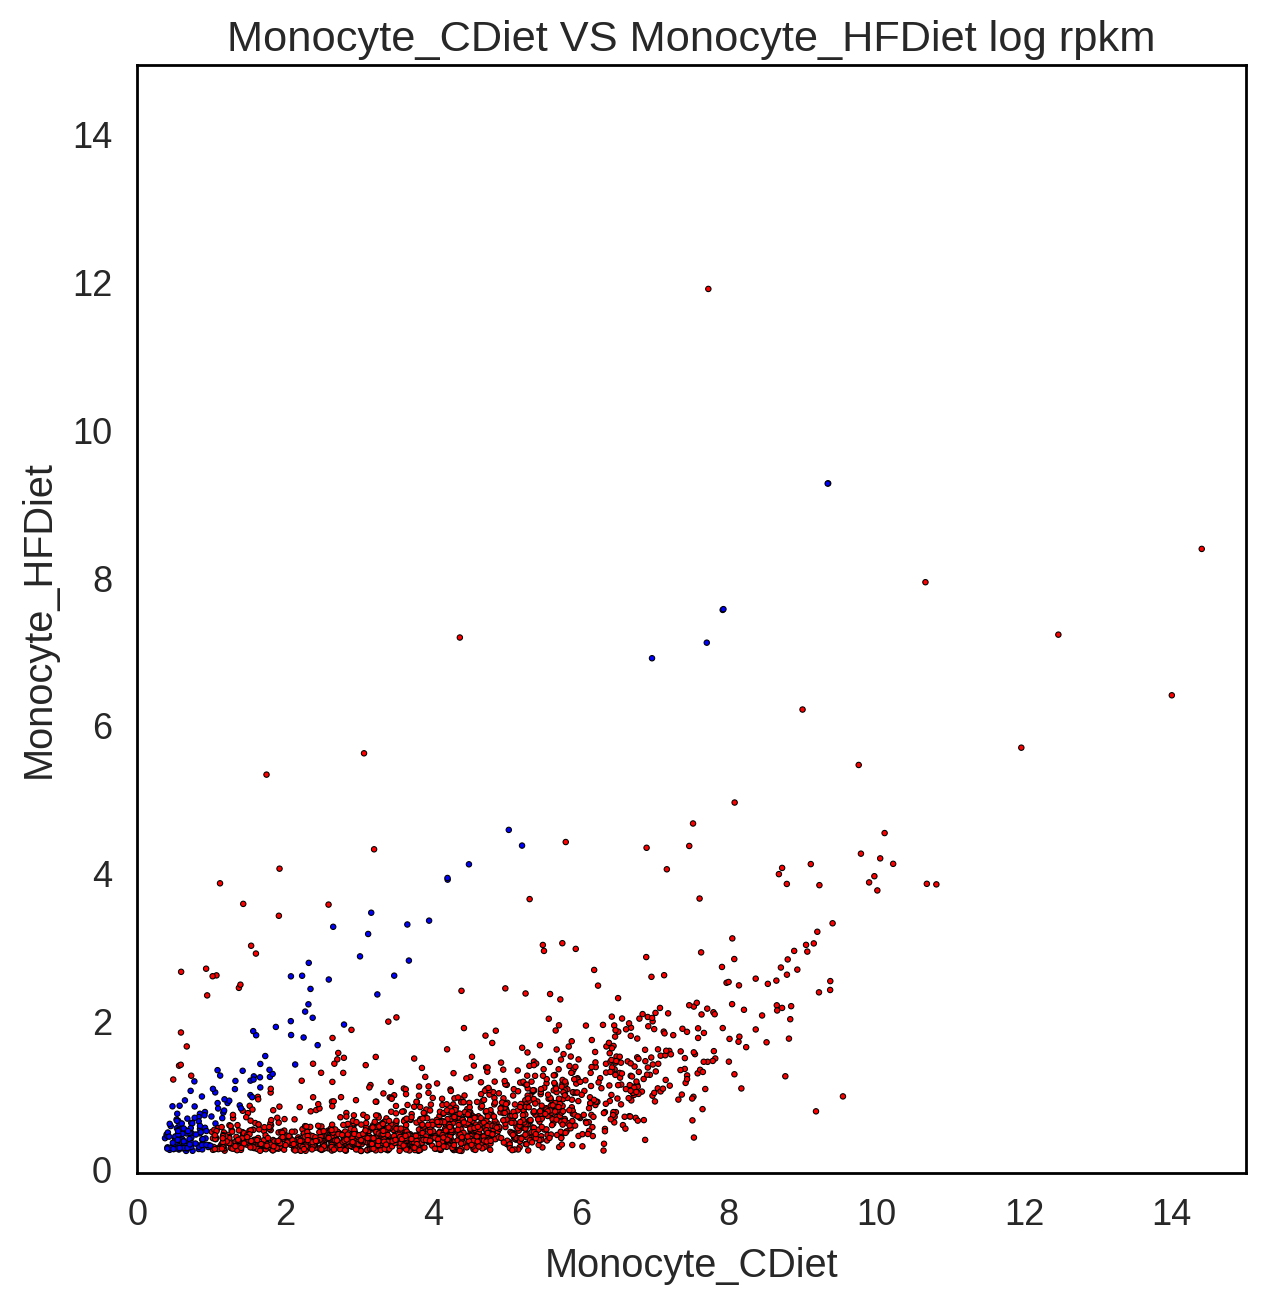

Monocyte_CDiet eWAT-Macrophage_CDiet


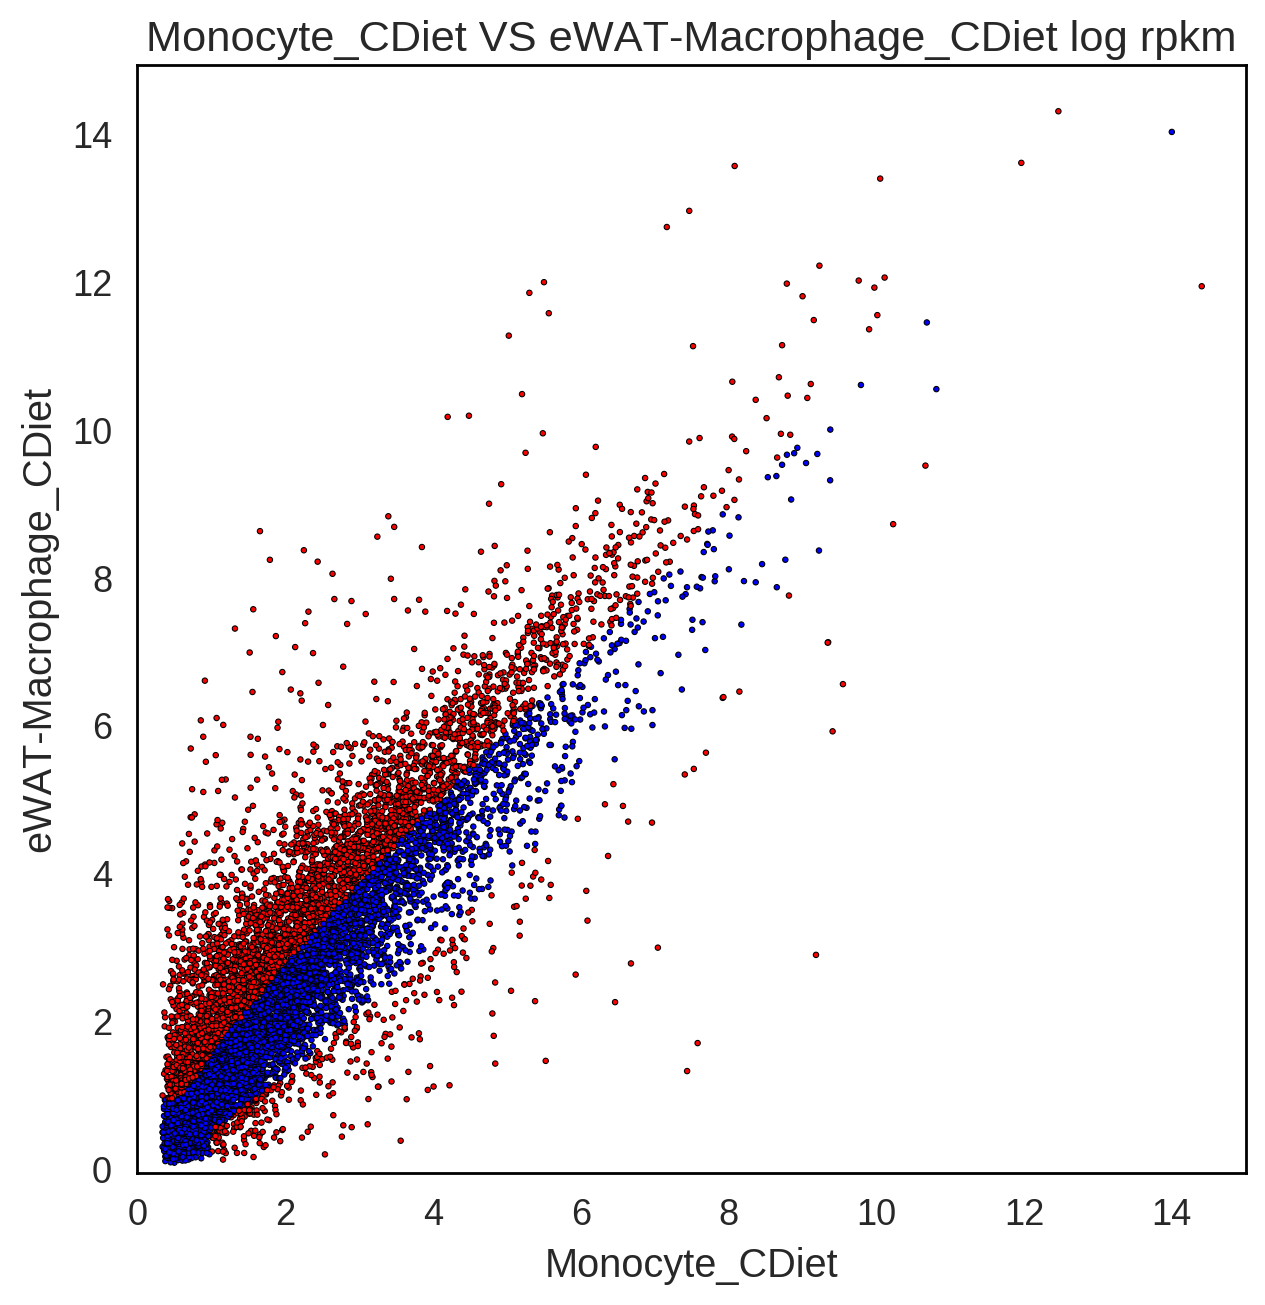

Monocyte_CDiet eWAT-Macrophage_HFDiet


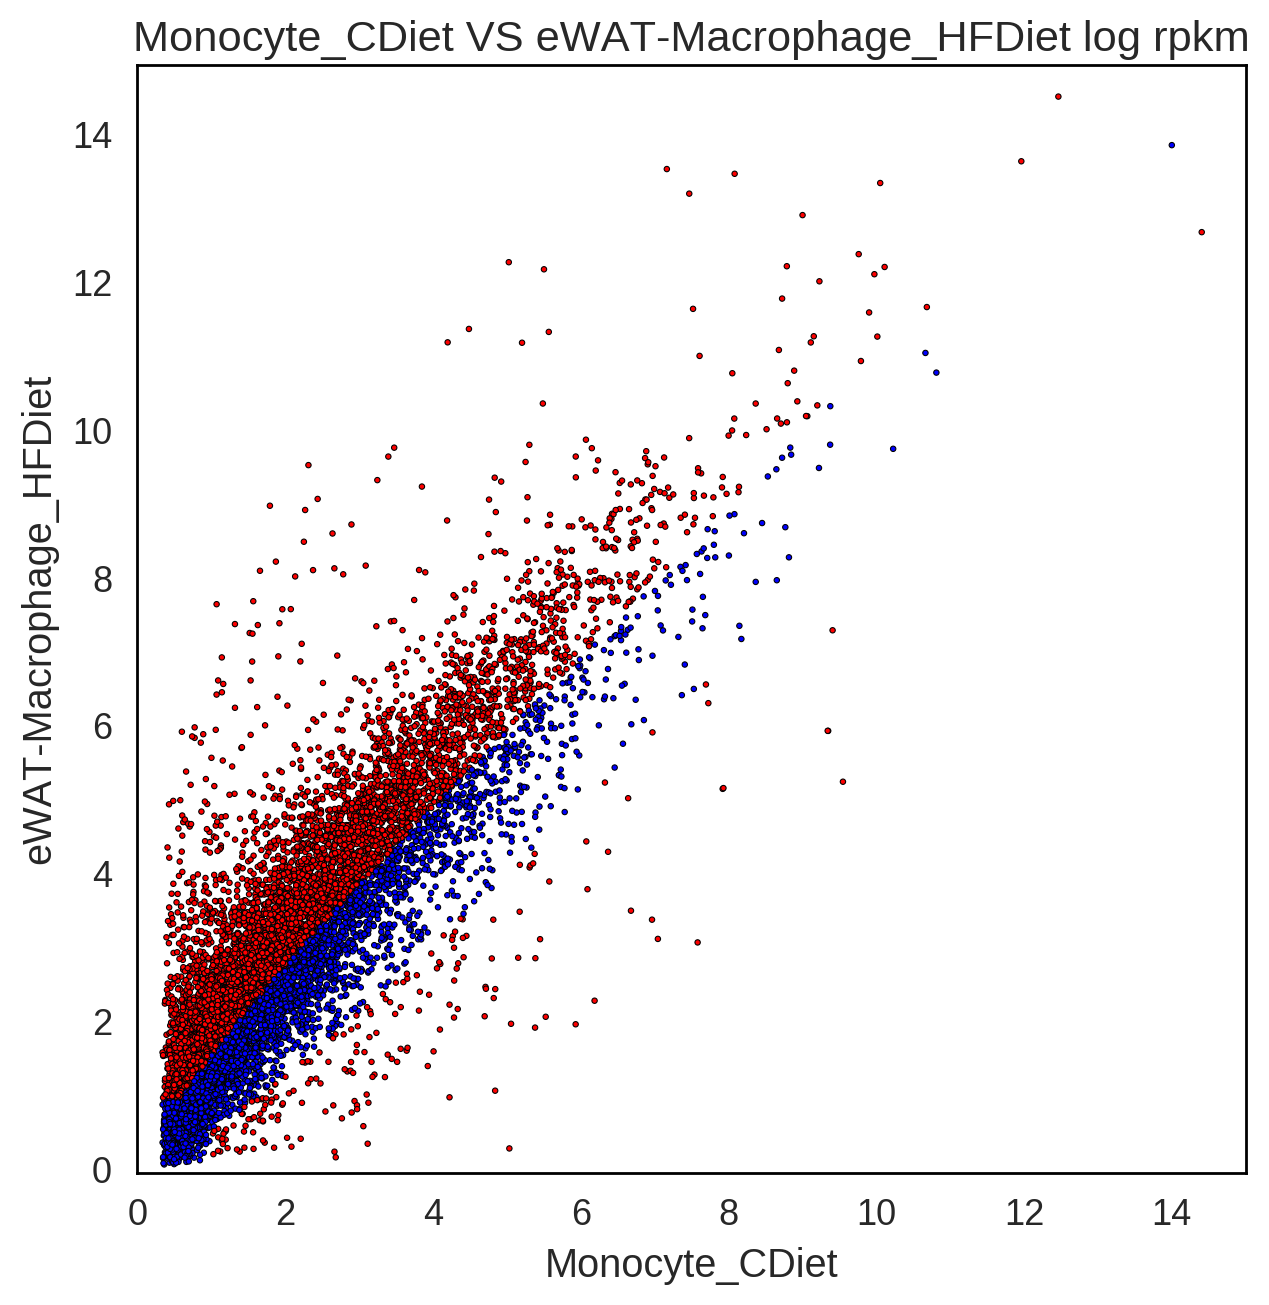

Monocyte_HFDiet eWAT-Macrophage_CDiet


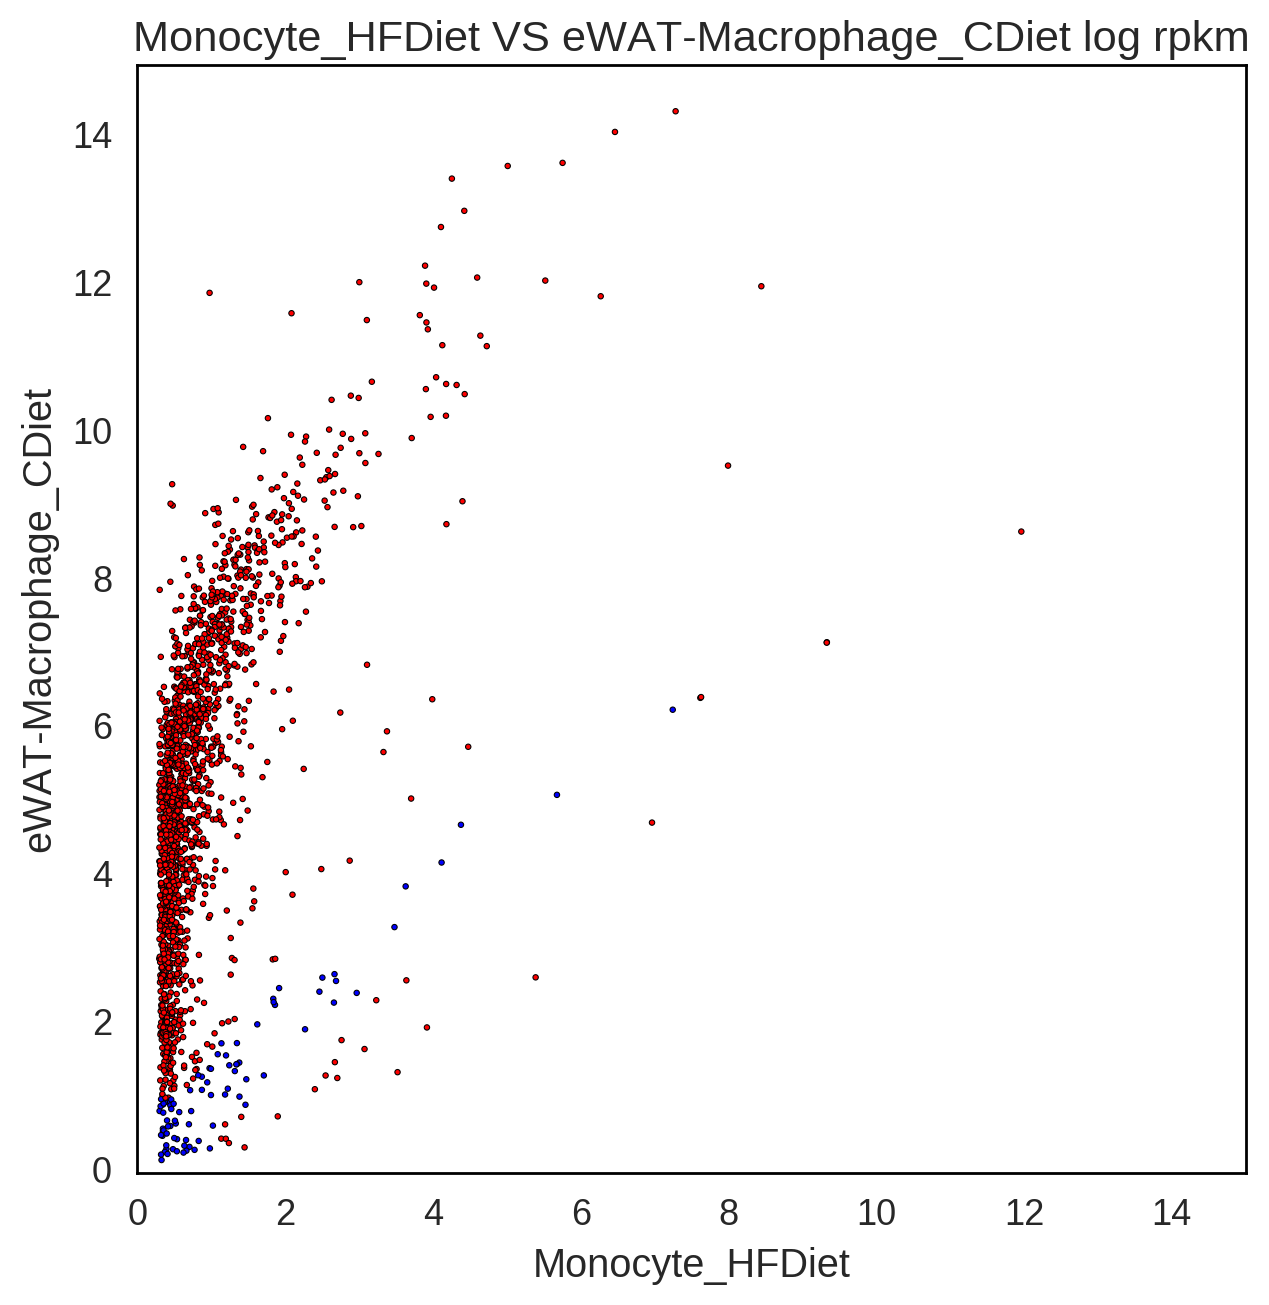

Monocyte_HFDiet eWAT-Macrophage_HFDiet


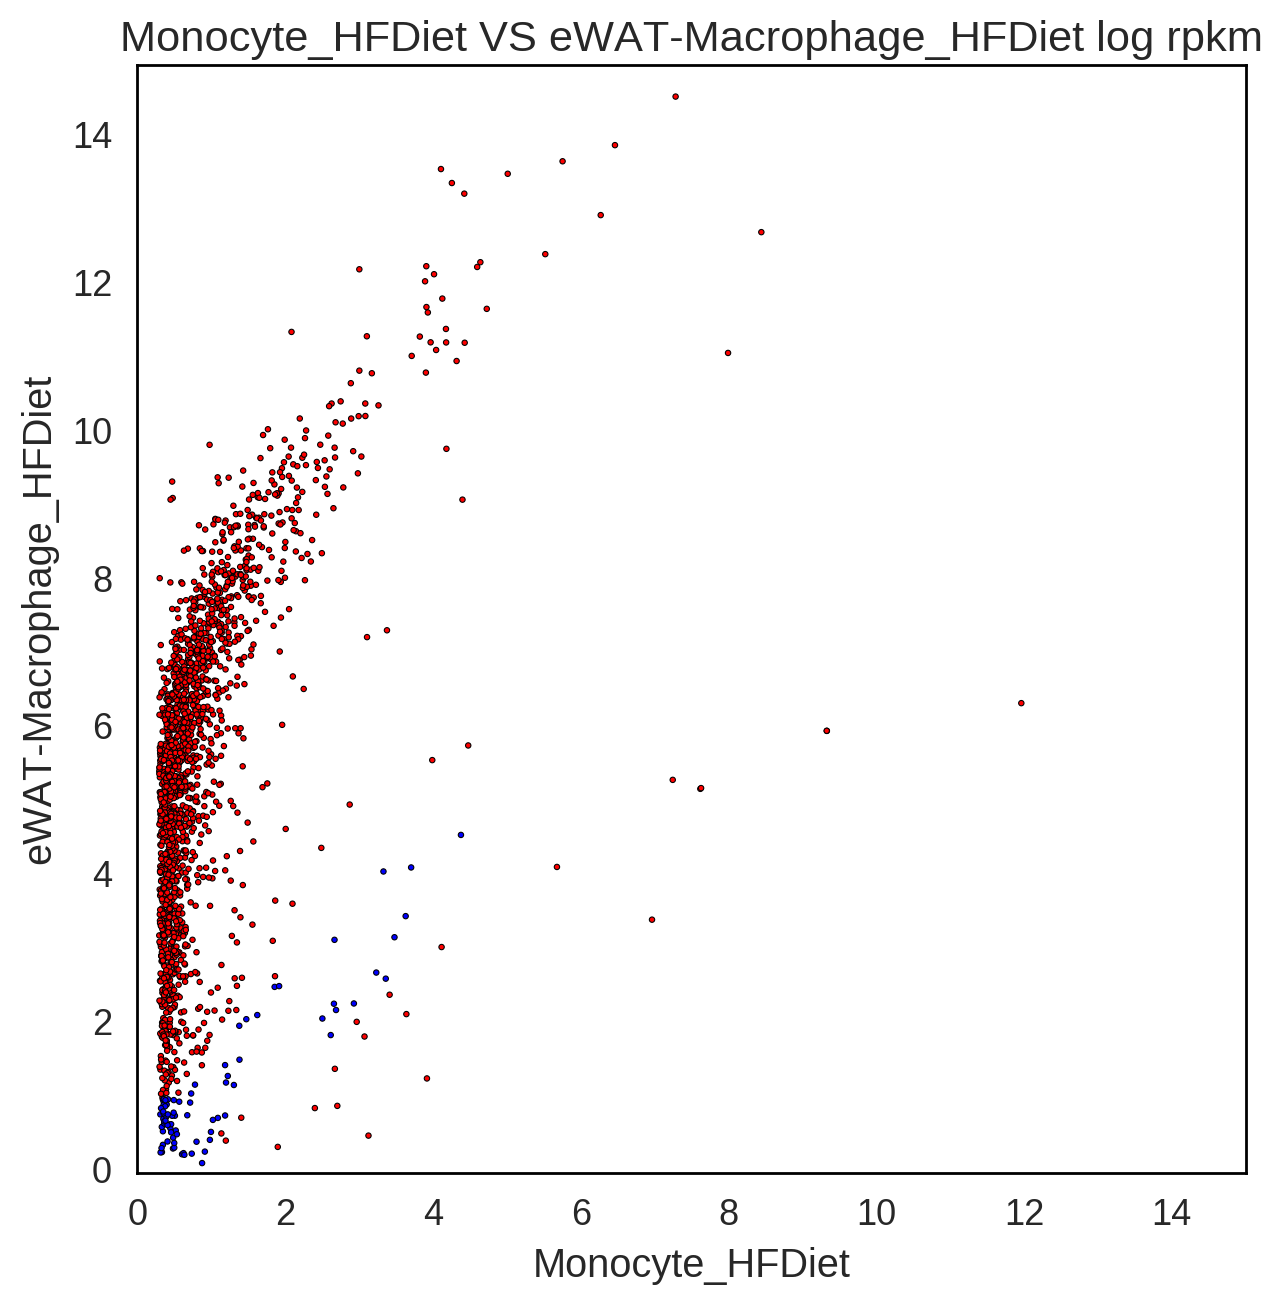

eWAT-Macrophage_CDiet eWAT-Macrophage_HFDiet


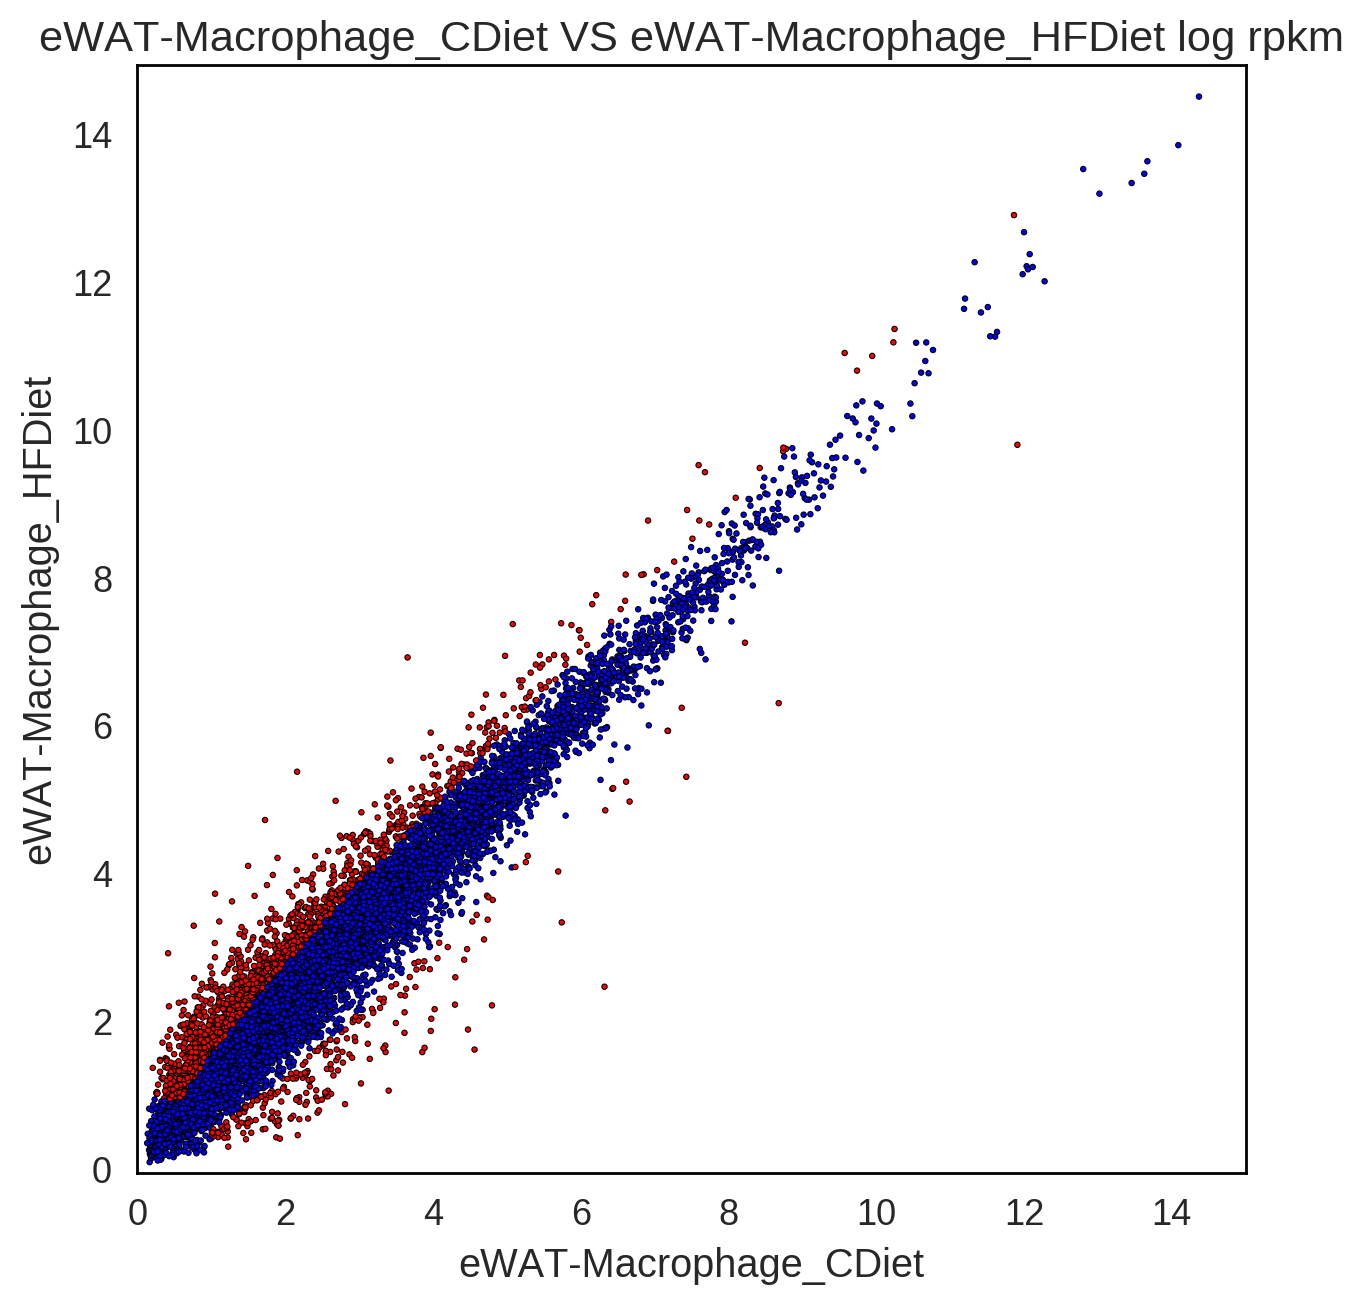

In [20]:
# %%capture
# plot meta scatter plots for different conditions
factor = 2.0
tagCutoff = 1.0

# for tag counts
# treatments = sorted(list(set(list(filtered_summary_frame['simpleTreatment']))))
treatments = list(np.array(filtered_summary_frame['strain'].values) + '_' 
                      + np.array(filtered_summary_frame['simpleTreatment'].values))
treatments = sorted(list(set(treatments)))


seenTreatments = set()

for i in range(len(treatments) - 1):
    for j in range(i + 1, len(treatments)):

        treatment1 = treatments[i]
        treatment2 = treatments [j]
        print(treatment1,treatment2)
        if treatment1 != treatment2:
            currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
            altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
            if altCurrentDir in seenTreatments:
                currentDir = altCurrentDir
            if not currentDir in seenTreatments:
                if not os.path.isdir(currentDir):
                    os.mkdir(currentDir)
                seenTreatments.add(currentDir)

            idrIntersection_frame_1 = pd.read_csv(idrDirectory + '/' +treatment1 + '_idrIntersection.tsv', sep='\t')
            intersecting_refseqs_1 = set(idrIntersection_frame_1['refseq'].values)
            idrIntersection_frame_2 = pd.read_csv(idrDirectory + '/' +treatment2 + '_idrIntersection.tsv', sep='\t')
            intersecting_refseqs_2 = set(idrIntersection_frame_2['refseq'].values)
            intersecting_refseqs = intersecting_refseqs_1.intersection(intersecting_refseqs_2)


            current_rpkm_frame = idrIntersection_frame_1.merge(idrIntersection_frame_2, on='refseq')
            current_rpkm_frame['gene'] = [refseq_gene_mapping[x] for x in current_rpkm_frame['refseq'].values]
            genes = current_rpkm_frame['gene'].values
            refseqs = current_rpkm_frame['refseq'].values

    #         read_list_1 = np.array([np.mean([float(y) for y in x.split(',')]) for x in current_rpkm_frame['count_x'].values])
    #         read_list_2 = np.array([np.mean([float(y) for y in x.split(',')]) for x in current_rpkm_frame['count_y'].values])
            cols1 = [x for x in filtered_rpkm_frame.columns.values if treatment1 in x]
            read_list_1 = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseqs)].loc[:,cols1].mean(axis=1).values
            cols2 = [x for x in filtered_rpkm_frame.columns.values if treatment2 in x]
            read_list_2 = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseqs)].loc[:,cols2].mean(axis=1).values

            log_read_list_1 = np.log2(read_list_1 + 1)
            log_read_list_2 = np.log2(read_list_2 + 1)

            coords = []
            labels = []
            colors = []
            fig, ax = plt.subplots()
            meta_geneList_up = []
            meta_geneList_down = []
            foldChanges = []
            for x in range(len(read_list_1)):
                foldChange = read_list_1[x]/read_list_2[x]
                if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                    if foldChange >= factor or foldChange <= 1.0/factor:
                        if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                            labels.append(genes[x])
                            if foldChange >= factor:
                                foldChanges.append(foldChange)
                                meta_geneList_up.append(refseqs[x])
                            if foldChange <= 1.0/factor:
                                foldChanges.append(-1.0/foldChange)
                                meta_geneList_down.append(refseqs[x])
                            coords.append((log_read_list_1[x],log_read_list_2[x]))
                        colors.append('red')
                    else:
                        colors.append('blue')
                else:
                    colors.append('blue')
            sns.set_style("whitegrid",{'axes.grid': False,
                          'axes.edgecolor': 'black'})
            plt.scatter(log_read_list_1,log_read_list_2, c= colors, marker='.', s=15);
            plt.xlabel(treatment1)
            plt.ylabel(treatment2)
            plt.title(treatment1 + " VS " + treatment2 + " log rpkm")
            
            xylim = max(max(log_read_list_1), max(log_read_list_2))
            plt.ylim(0,xylim)
            plt.xlim(0,xylim)
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,15))
            ax.set_ylim((0,15))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 
            
#             for x in range(len(coords)):
#                 gene = labels[x]
#                 ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
#                         textcoords='offset points', ha='center', va='bottom',
#                         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
            plt.savefig(workingDirectory + "/" + currentDir + "/" +treatment1 + '_' + treatment2 + "_merged_log.pdf")
            plt.show()
     
        
        
        

## Clustering

In [109]:
idr_intersection_frame = pd.read_csv('idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_intersection_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
idr_intersection_frame.columns = columns    
idr_intersection_frame['gene'] = [x.split("|")[0] for x in idr_intersection_frame['Annotation/Divergence']]
columns = list(idr_intersection_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_intersection_frame = idr_intersection_frame[columns]
idr_intersection_frame.index = idr_intersection_frame['refseq'].values
idr_intersection_frame = idr_intersection_frame.ix[:,9:]

In [110]:
mono_control_refseqs =  pd.read_csv('idr/Monocyte_CDiet_idrIntersection.tsv', sep='\t')['refseq'].values
mono_hf_refseqs =  pd.read_csv('idr/Monocyte_HFDiet_idrIntersection.tsv', sep='\t')['refseq'].values
macrophage_control_refseqs =  pd.read_csv('idr/eWAT-Macrophage_CDiet_idrIntersection.tsv', sep='\t')['refseq'].values
macrophage_hf_refseqs =  pd.read_csv('idr/eWAT-Macrophage_HFDiet_idrIntersection.tsv', sep='\t')['refseq'].values

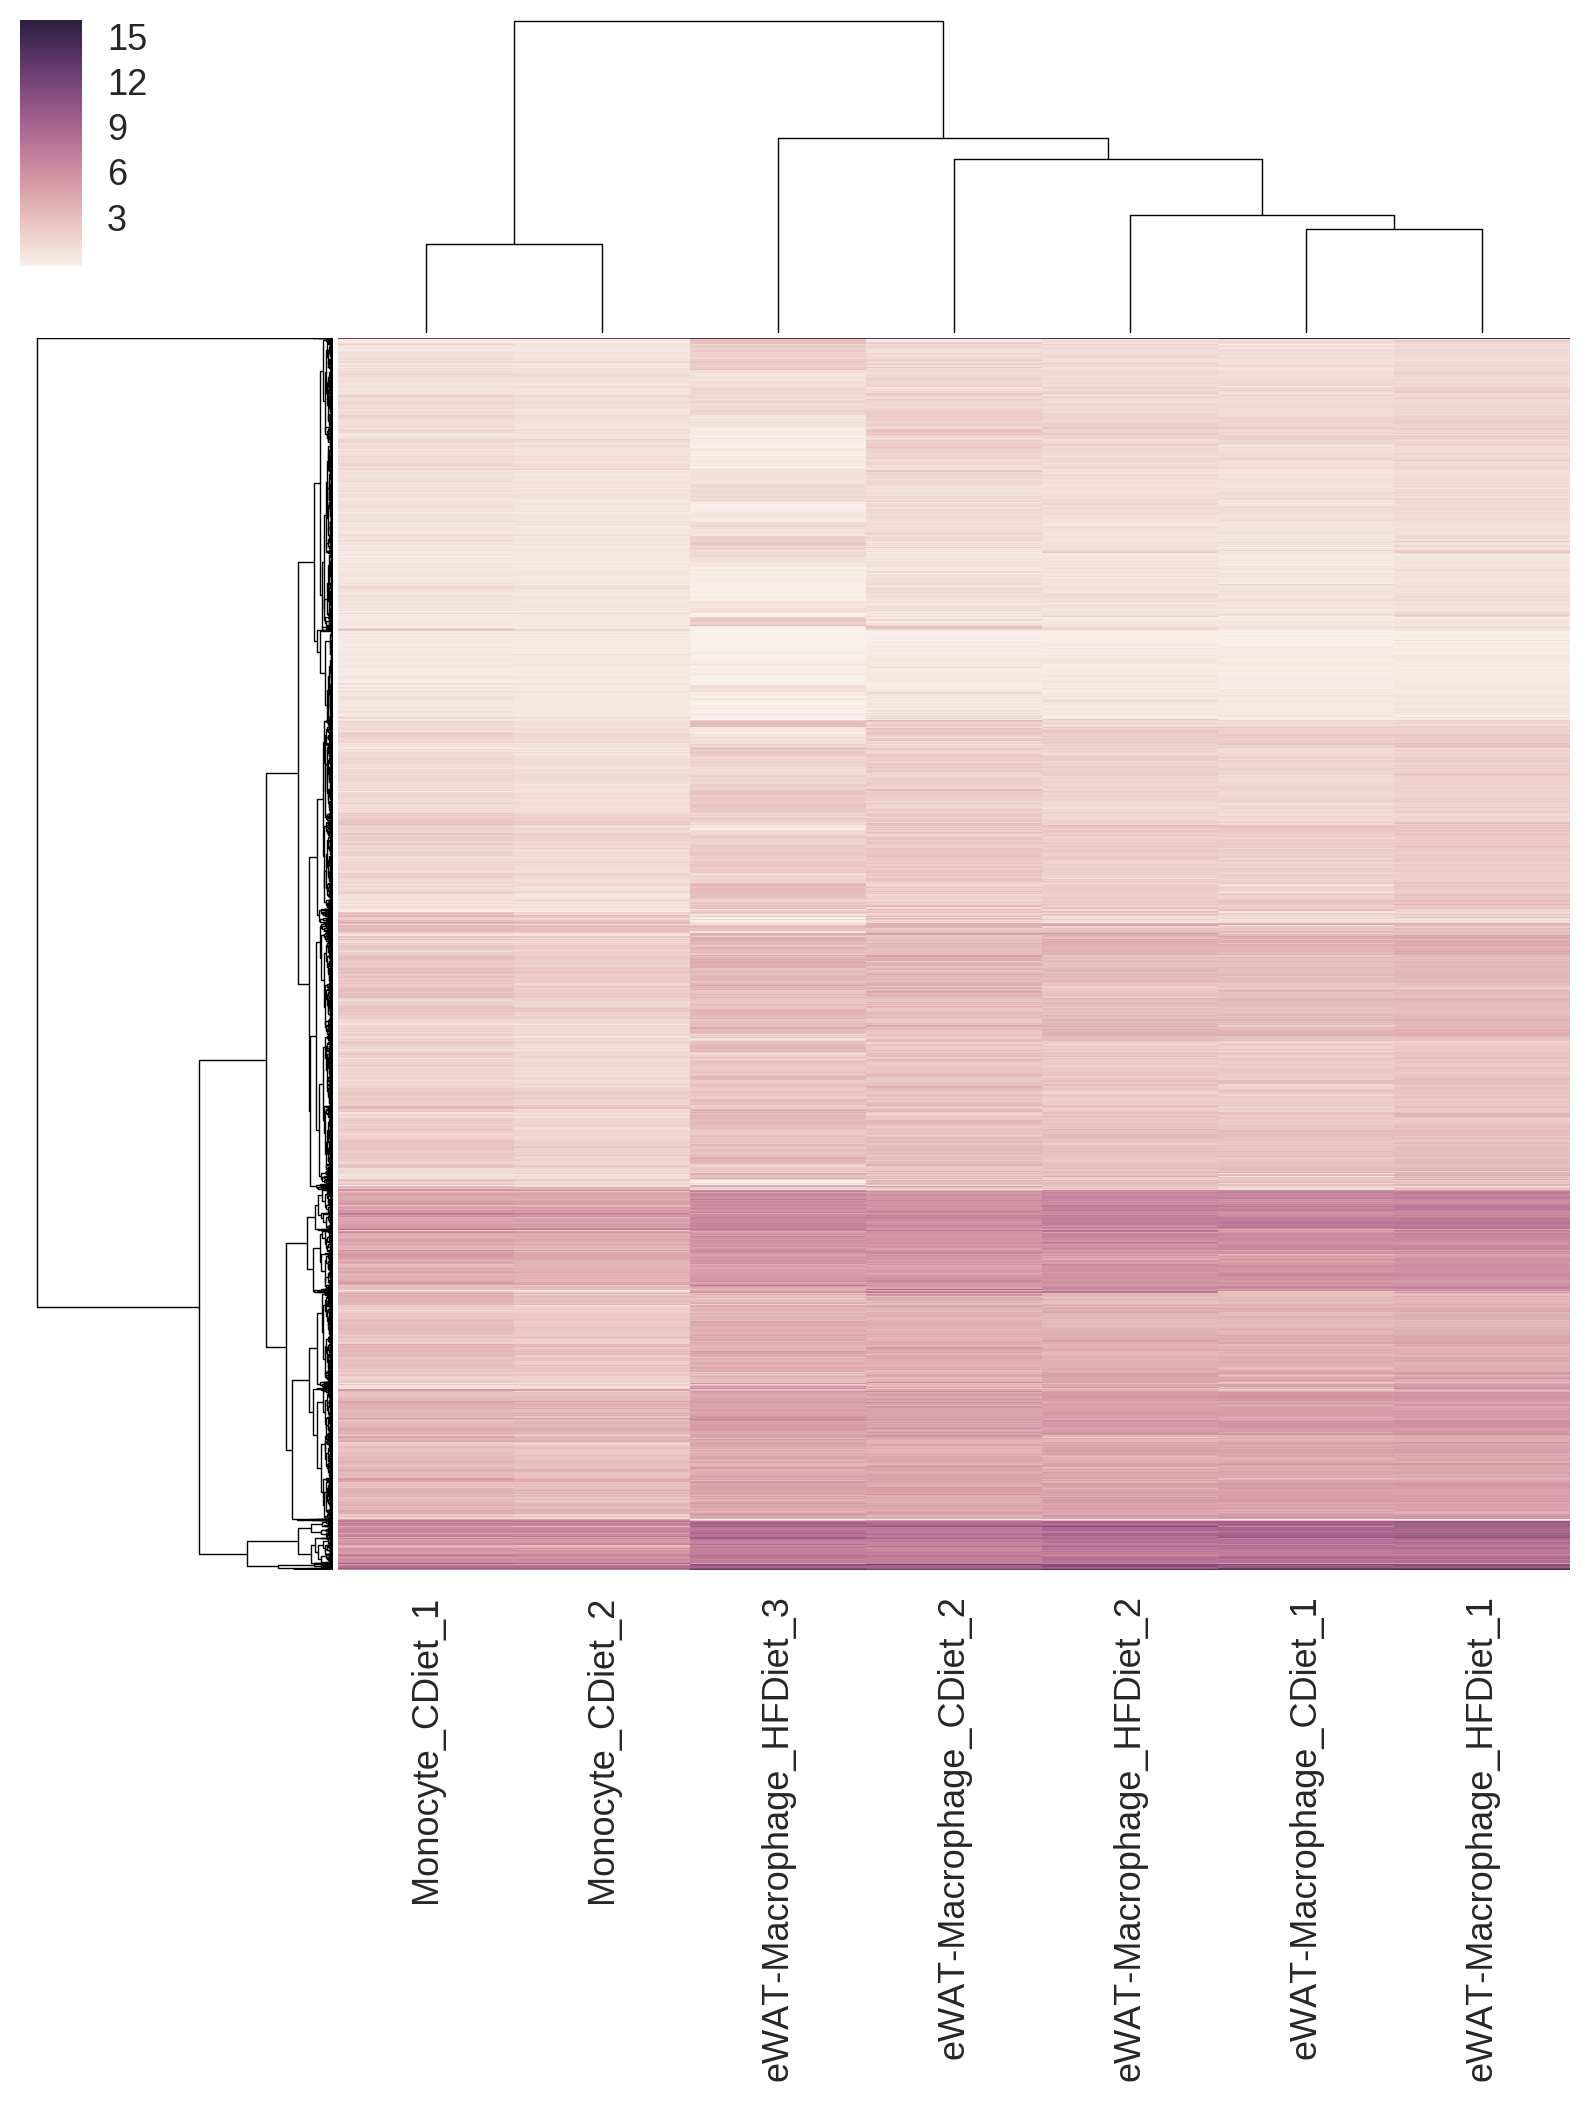

In [111]:
sns.clustermap(np.log2(idr_intersection_frame+1), yticklabels=False)